# Supplemental Information

In [1]:
import glob
import itertools
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set(font_scale = 1.8, style = 'darkgrid')
palette4 = sns.color_palette(['#C7243A', '#EDAD0B', '#23AC0E', '#3261AB'], 4)
palette6 = sns.color_palette(["#C7243A", "#EDAD0B", "#A4C520", "#23AC0E", "#3261AB", "#744199"], 6)
palette10 = sns.color_palette(["#C7243A", "#E47B12", "#F6CA06", "#F1E90A", "#A4C520", 
                               "#069F27", '#009F8C', '#007AB7', '#485FA4', '#614F9B'], 10)
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
COLUMNS = {
    'network_type': str,
    '$h_G$': int,
    '$h_R$': int,
    'b': float,
    'μ': float,
    'δ': float,
    'interaction_rule': str,
    'update_rule': str,
    'trial': int,
    'cooperator_rate': float
}


GROUPBY_COLUMNS = [c for c in COLUMNS if c not in ['trial', 'cooperator_rate']]


def load_df(csv_file_name: str) -> pd.DataFrame:
    _df = pd.read_csv(csv_file_name, header=None, names=COLUMNS.keys(), dtype=COLUMNS)
    # return _df.groupby(GROUPBY_COLUMNS).agg({'cooperator_rate': np.mean}).reset_index()
    return _df


def narrow_down_df(_df: pd.DataFrame, network_type: str, interaction_rule: str, update_rule: str) -> pd.DataFrame:
    return _df[(_df.network_type == network_type) & (_df.interaction_rule == interaction_rule) & (_df.update_rule == update_rule)][[
        '$h_G$', '$h_R$', 'b', 'δ', 'μ', 'cooperator_rate'
    ]].reset_index(drop=True)


def plot(_df: pd.DataFrame, interaction_rule: str, x_axis: str) -> sns.axisgrid.FacetGrid:
    if x_axis == 'hG':
        _x_axis, _hue = '$h_G$', '$h_R$'
    elif x_axis == 'hR':
        _x_axis, _hue = '$h_R$', '$h_G$'

    if interaction_rule == 'Group' and x_axis == 'hR':
        _df = _df[_df['$h_G$'] == 1]
        _g = sns.relplot(kind='line', x=_x_axis, y='cooperator_rate', hue='b', col='δ', style='μ', palette=palette4, data=_df)
    else:
        _palette = palette6 if len(set(_df[_hue])) == 6 else palette10
        _g = sns.relplot(kind='line', x=_x_axis, y='cooperator_rate', hue=_hue, row='δ', col='b', style='μ', palette=_palette, data=_df)

    _g.set_ylabels('Frequency of cooperators')
    _g.set(ylim=(-0.02, 1.02))
    _ax = _g.axes[0, 0]
    _ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    _ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
    return _g

    
def file_name(network_type: str, interaction_rule: str, update_rule: str, x_axis: str) -> str:
    network_type_dict = {
        'scale_free_4': 'sf',
        'random_4': 'rn',
        'regular_4': 'rg'
    }

    interaction_rule_dict = {
        'PairWise': '2',
        'Group': 'N'
    }

    return 'img/SI1_{}_{}_{}_{}.jpg'.format(
        network_type_dict[network_type],
        interaction_rule_dict[interaction_rule],
        update_rule,
        x_axis
    )


def save_and_show(network_type: str, interaction_rule: str, update_rule: str, x_axis: str) -> pd.DataFrame:
    print('{}, {}, {}'.format(network_type, interaction_rule, update_rule))
    _file_name = file_name(network_type, interaction_rule, update_rule, x_axis)
    plt.savefig(_file_name, format='jpeg', bbox_inches='tight')
    plt.show()


def run(_df: pd.DataFrame, x_axis: str) -> None:
    for (_, _network_type, _interaction_rule, _update_rule) in _df[['network_type', 'interaction_rule', 'update_rule']].drop_duplicates().itertuples():
        _narrow_down_df = narrow_down_df(_df, _network_type, _interaction_rule, _update_rule)
        plot(_narrow_down_df, _interaction_rule, x_axis)
        save_and_show(_network_type, _interaction_rule, _update_rule, x_axis)


In [3]:
%%time
dir_names = ['clean_data']
file_list = list(itertools.chain.from_iterable([glob.glob('../data/{}/*.csv'.format(dir_name)) for dir_name in dir_names]))
df_list = [load_df(file) for file in file_list]
df_raw = pd.concat(df_list).reset_index(drop=True)
df = df_raw.groupby(GROUPBY_COLUMNS).agg({'cooperator_rate': [len, np.mean, np.std]}).reset_index()
df.columns = GROUPBY_COLUMNS + ['trial', 'cooperator_rate', 'std']

# group_df
group_df = df[
    (df.interaction_rule == 'Group') &
    (df.b.isin([3.0, 4.0, 5.0, 6.0]))
]
group_df = group_df[
    ((df.network_type == 'scale_free_4') & (df['$h_G$'] <= 6)  & (df['$h_R$'] <= 6)) |
    ((df.network_type == 'random_4')     & (df['$h_G$'] <= 10) & (df['$h_R$'] <= 10)) |
    ((df.network_type == 'regular_4')    & (df['$h_G$'] <= 10)  & (df['$h_R$'] <= 10))
]

# pair_df
pair_df = df[
    (df.interaction_rule == 'PairWise') &
    (df['$h_G$'] <= 6) &
    (df['$h_R$'] <= 6) &
    (df.b.isin([1.1, 1.2, 1.3, 1.4]))
]

CPU times: user 1.2 s, sys: 183 ms, total: 1.38 s
Wall time: 1.4 s


<timed exec>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
pair_df[pair_df.update_rule == 'BD'].groupby(['network_type']).agg({'cooperator_rate': [np.mean, np.std]}).reset_index()

network_type cooperator_rate          
                           mean       std
0      random_4        0.000091  0.000202
1     regular_4        0.000109  0.000244
2  scale_free_4        0.000104  0.000215

random_4, Group, BD


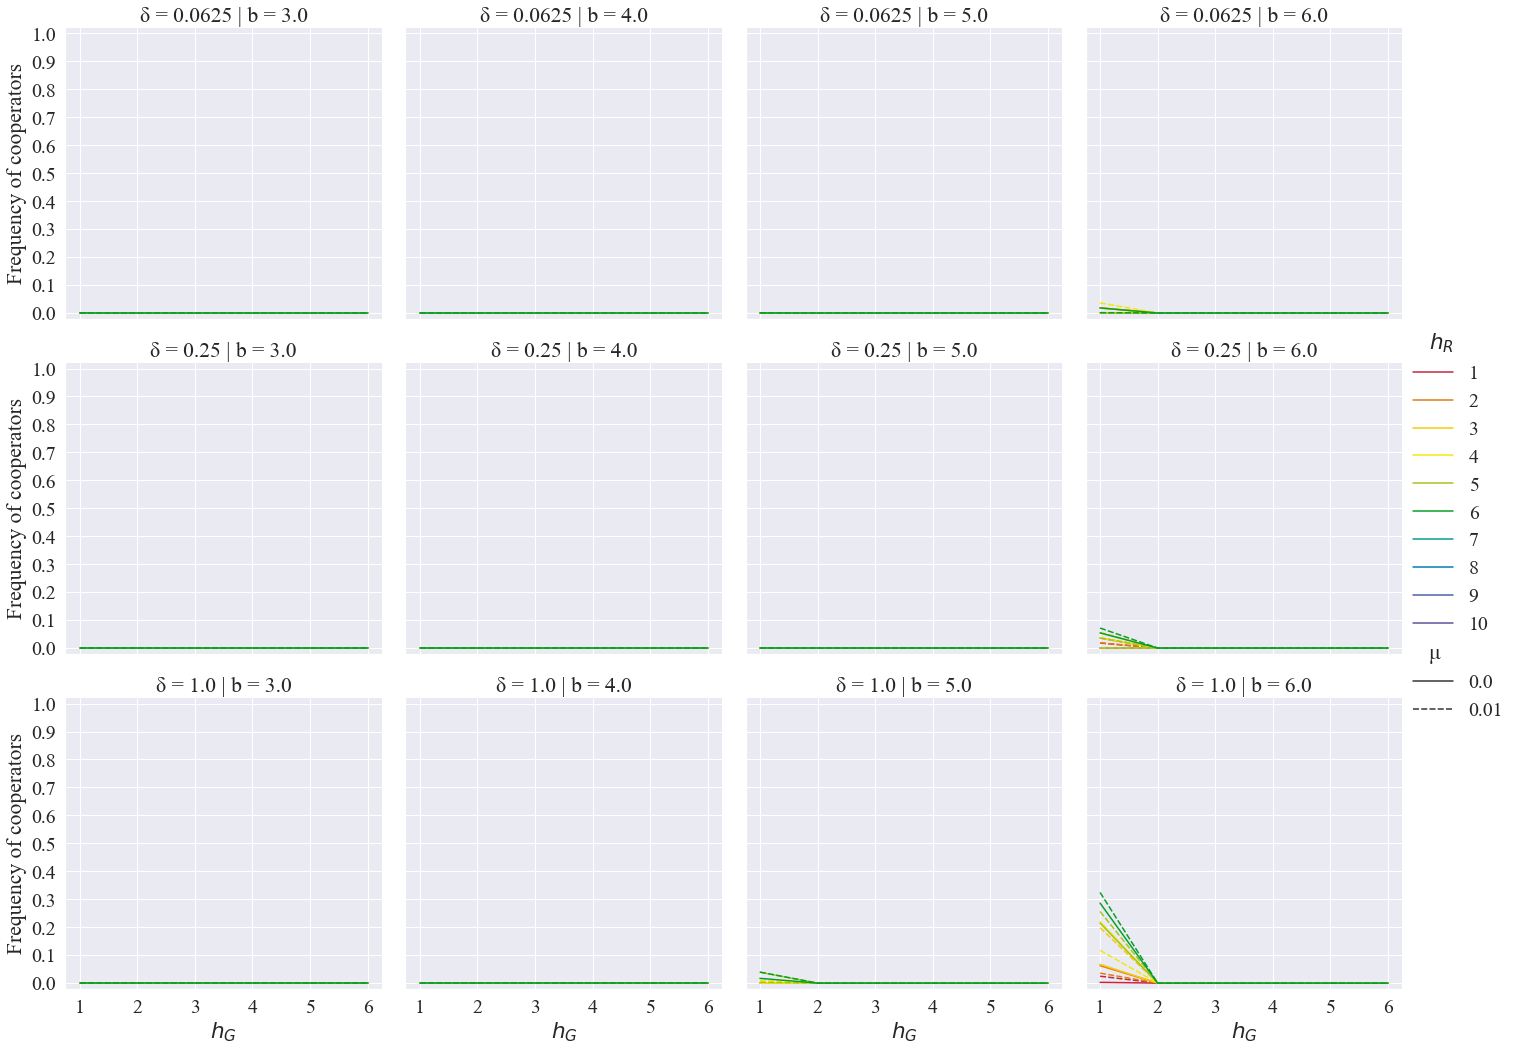

random_4, Group, DB


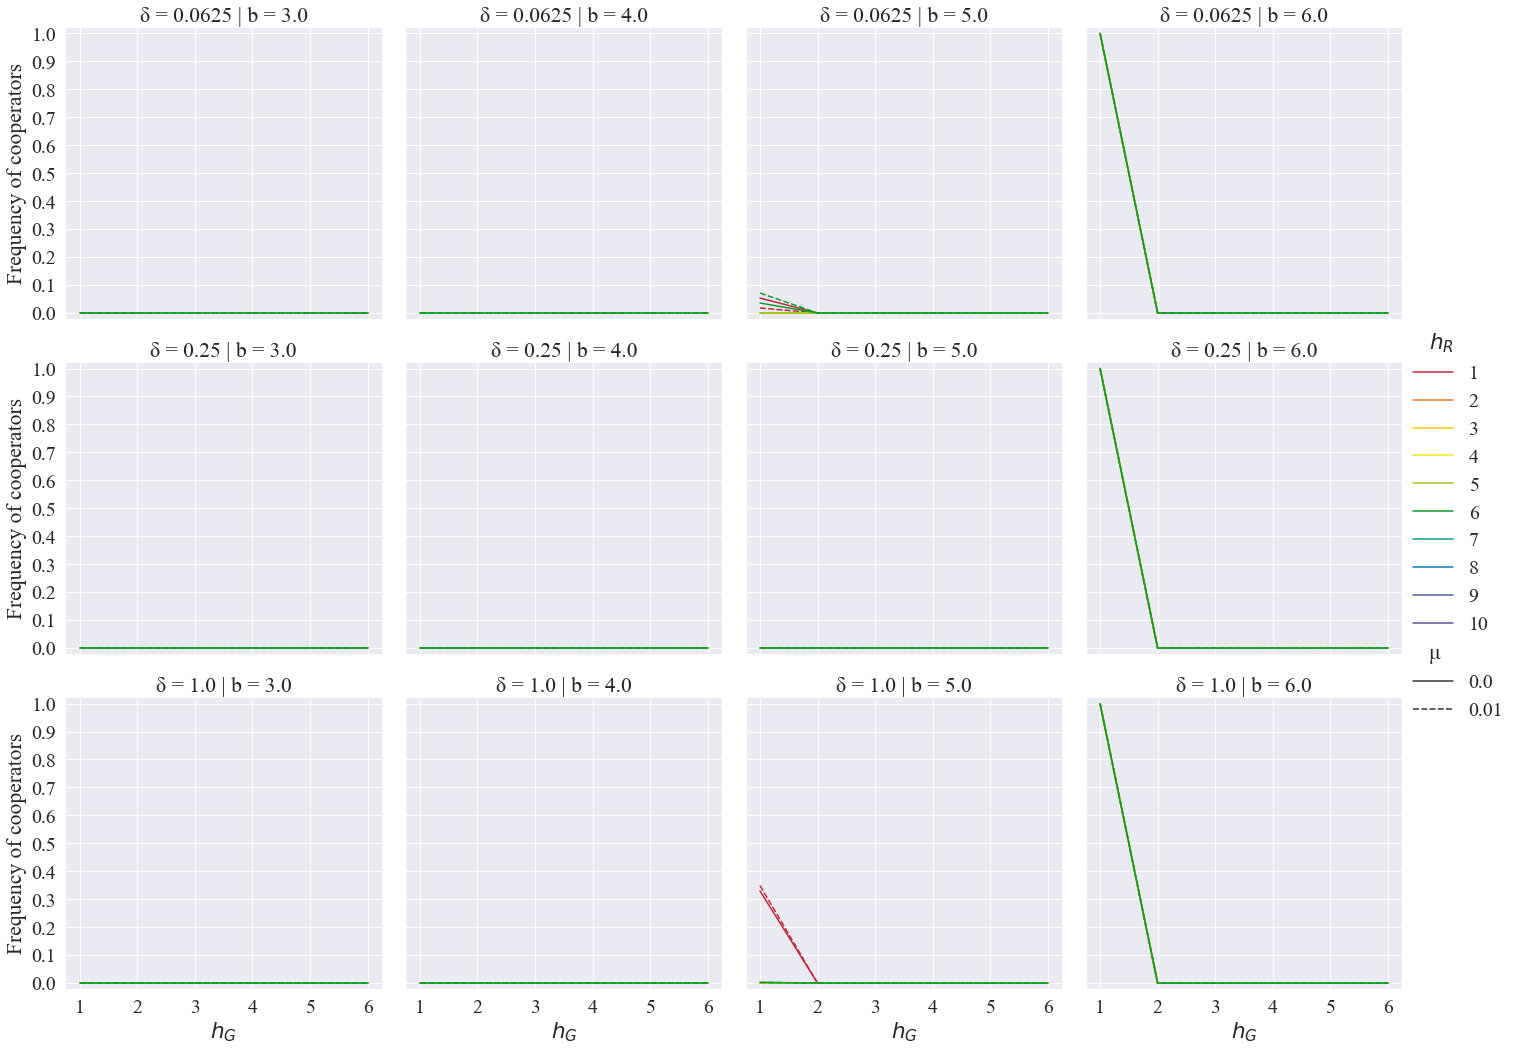

random_4, Group, IM


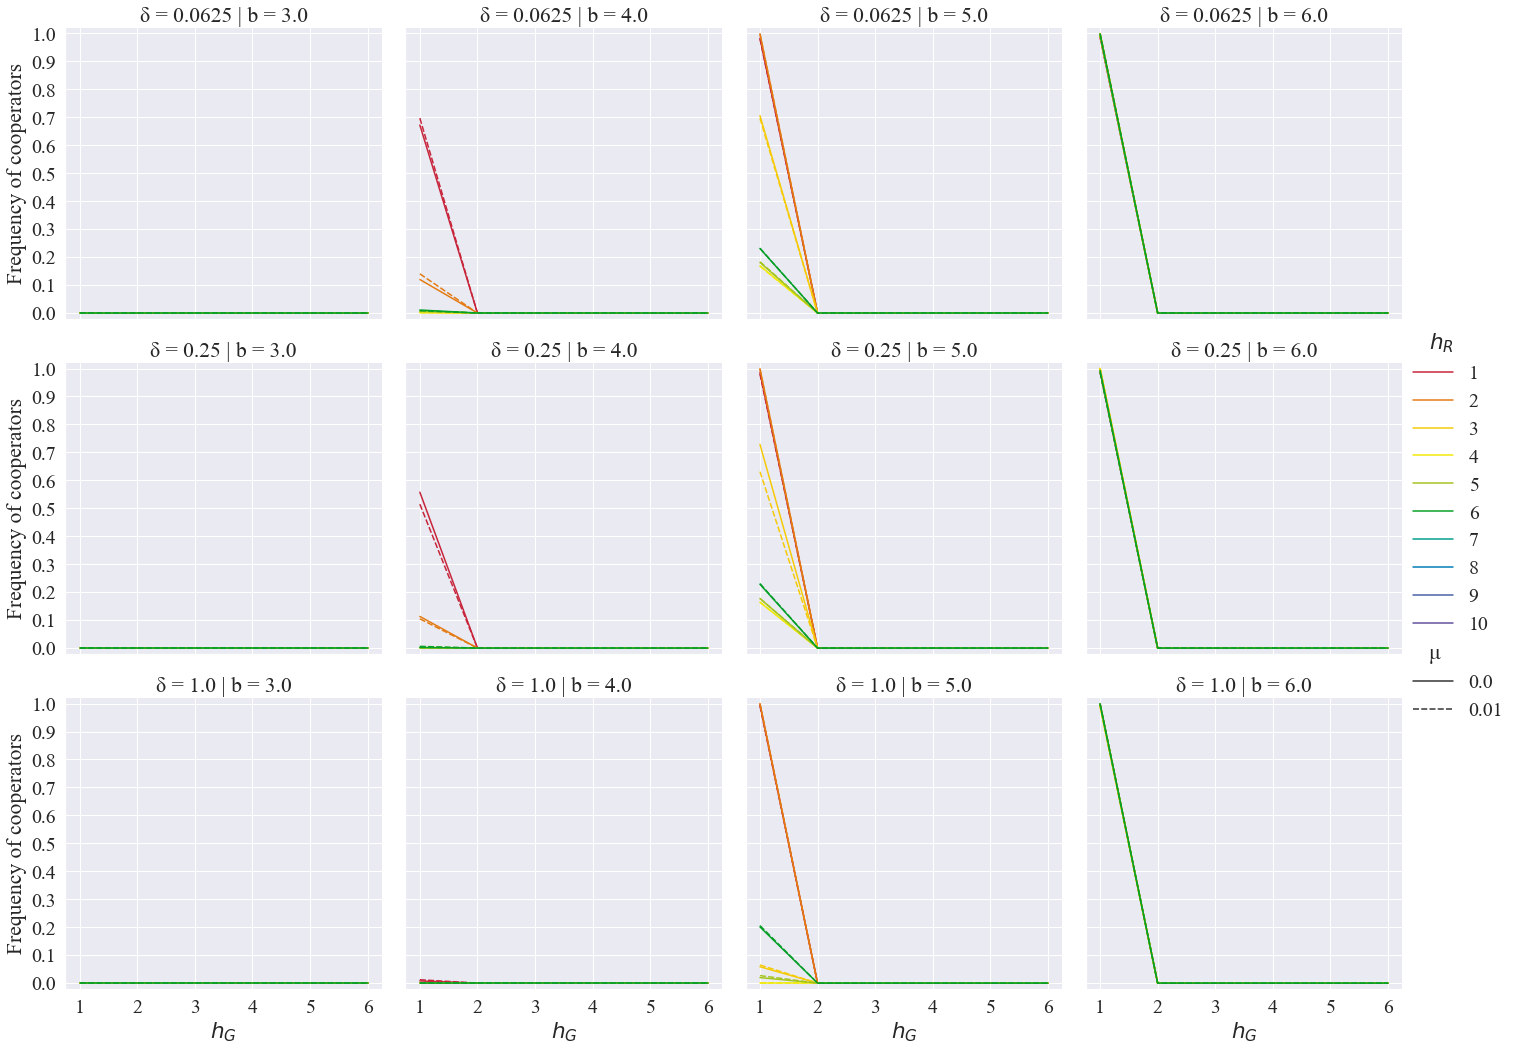

regular_4, Group, BD


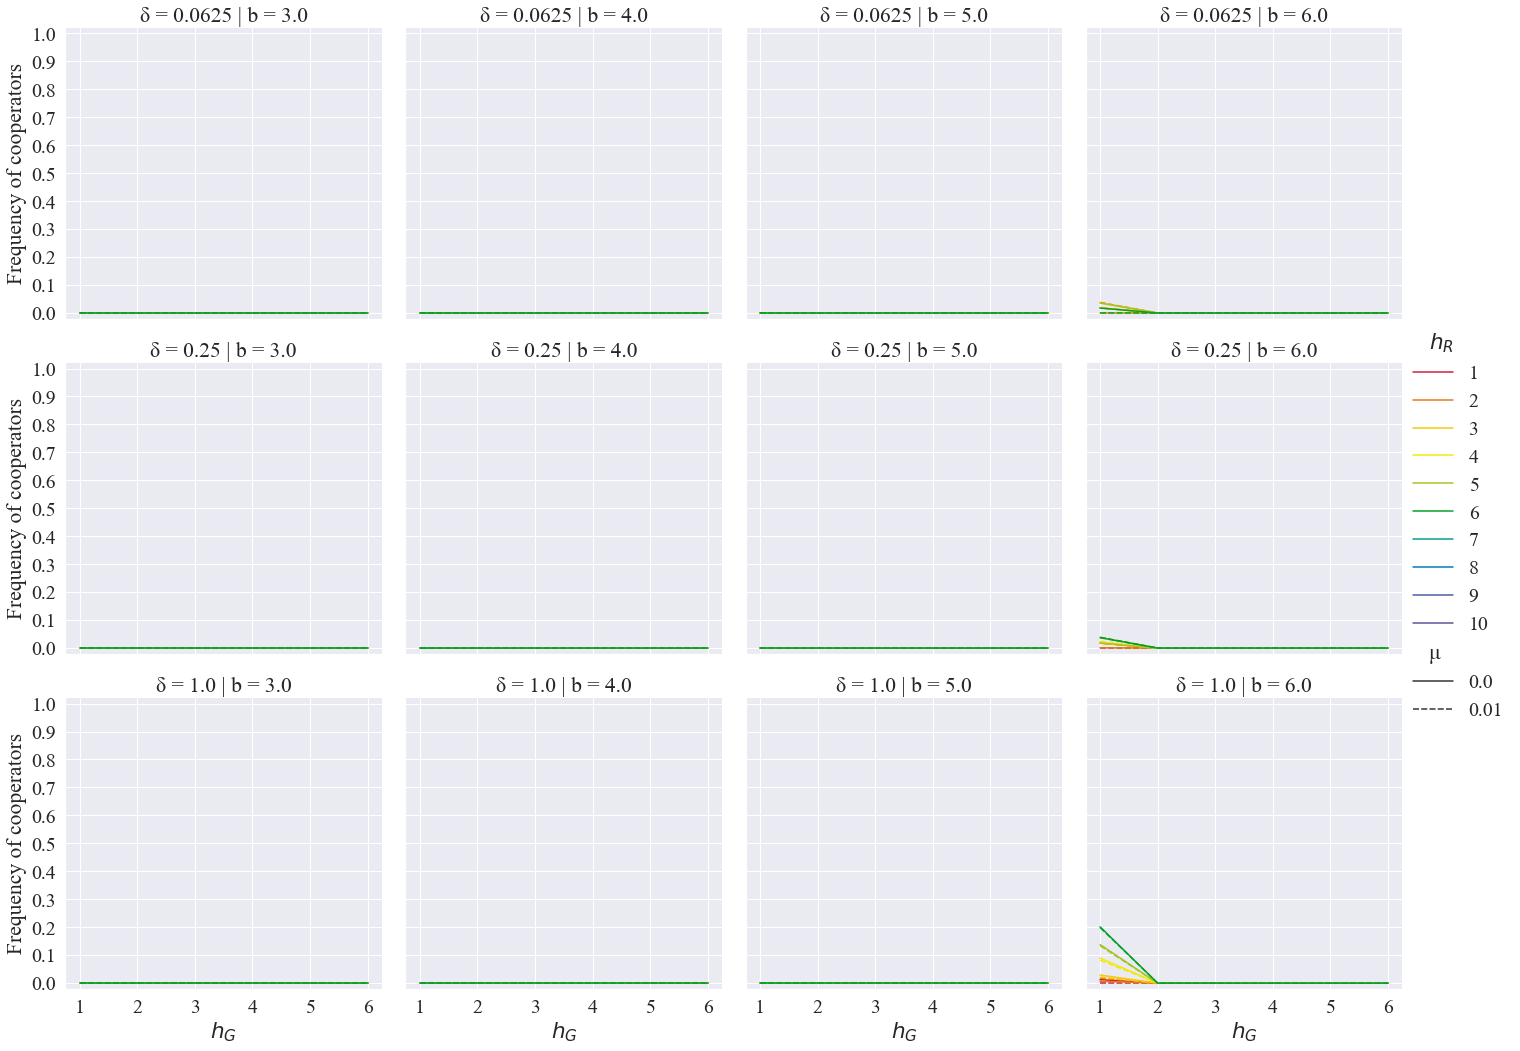

regular_4, Group, DB


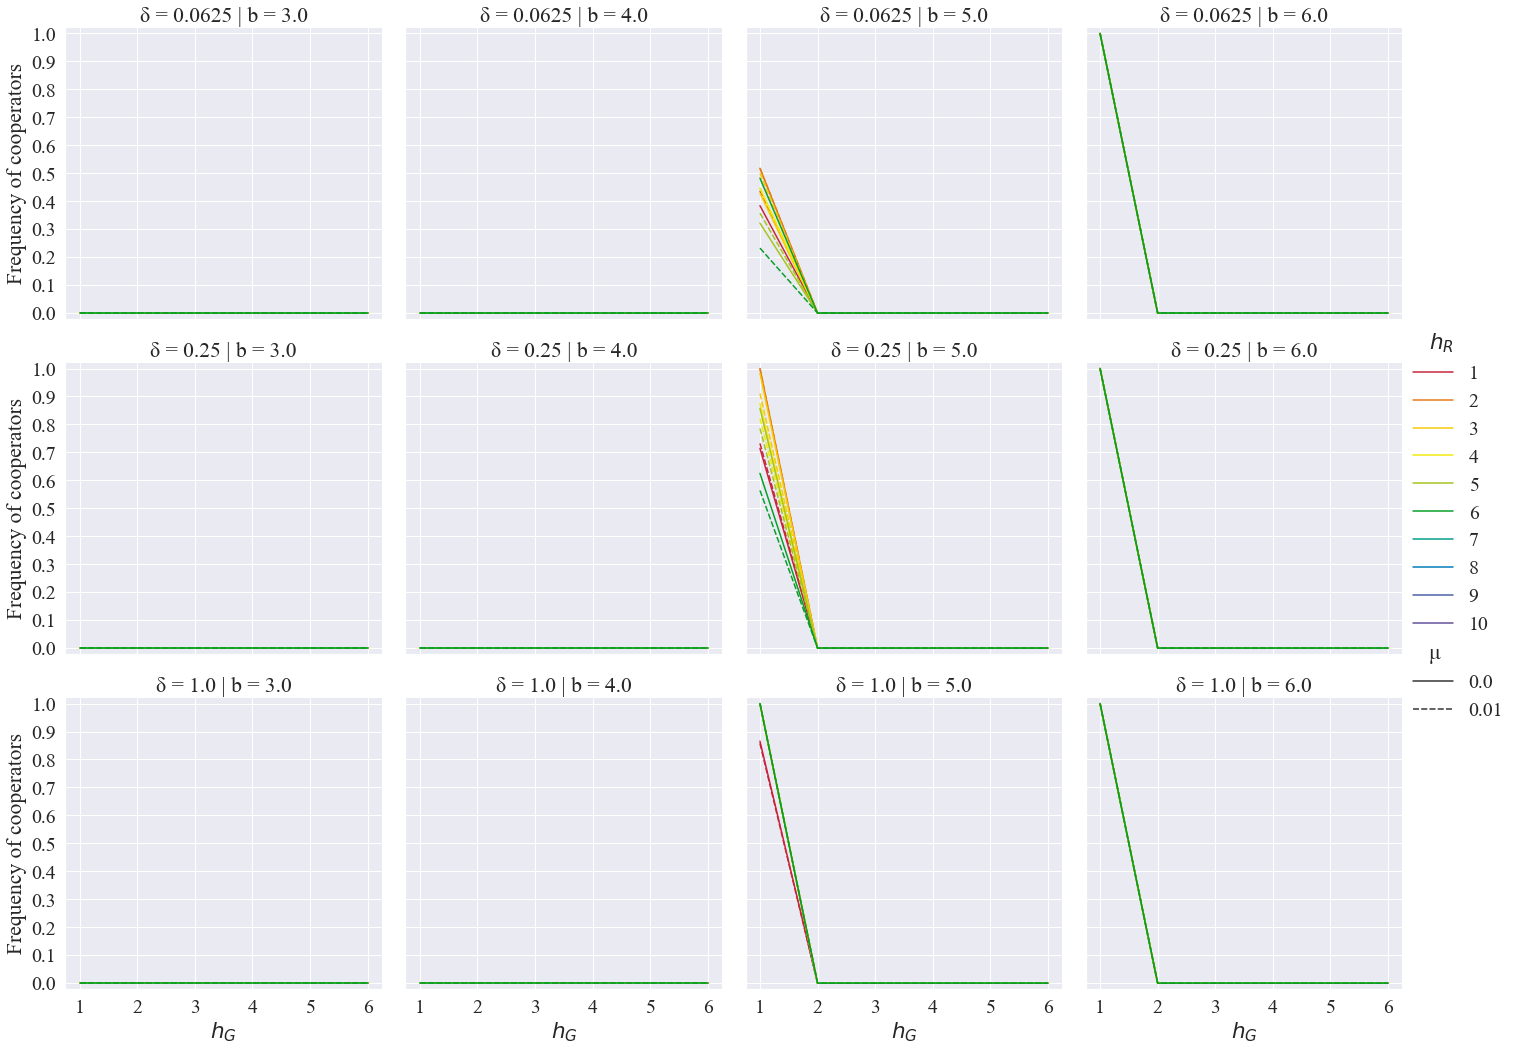

regular_4, Group, IM


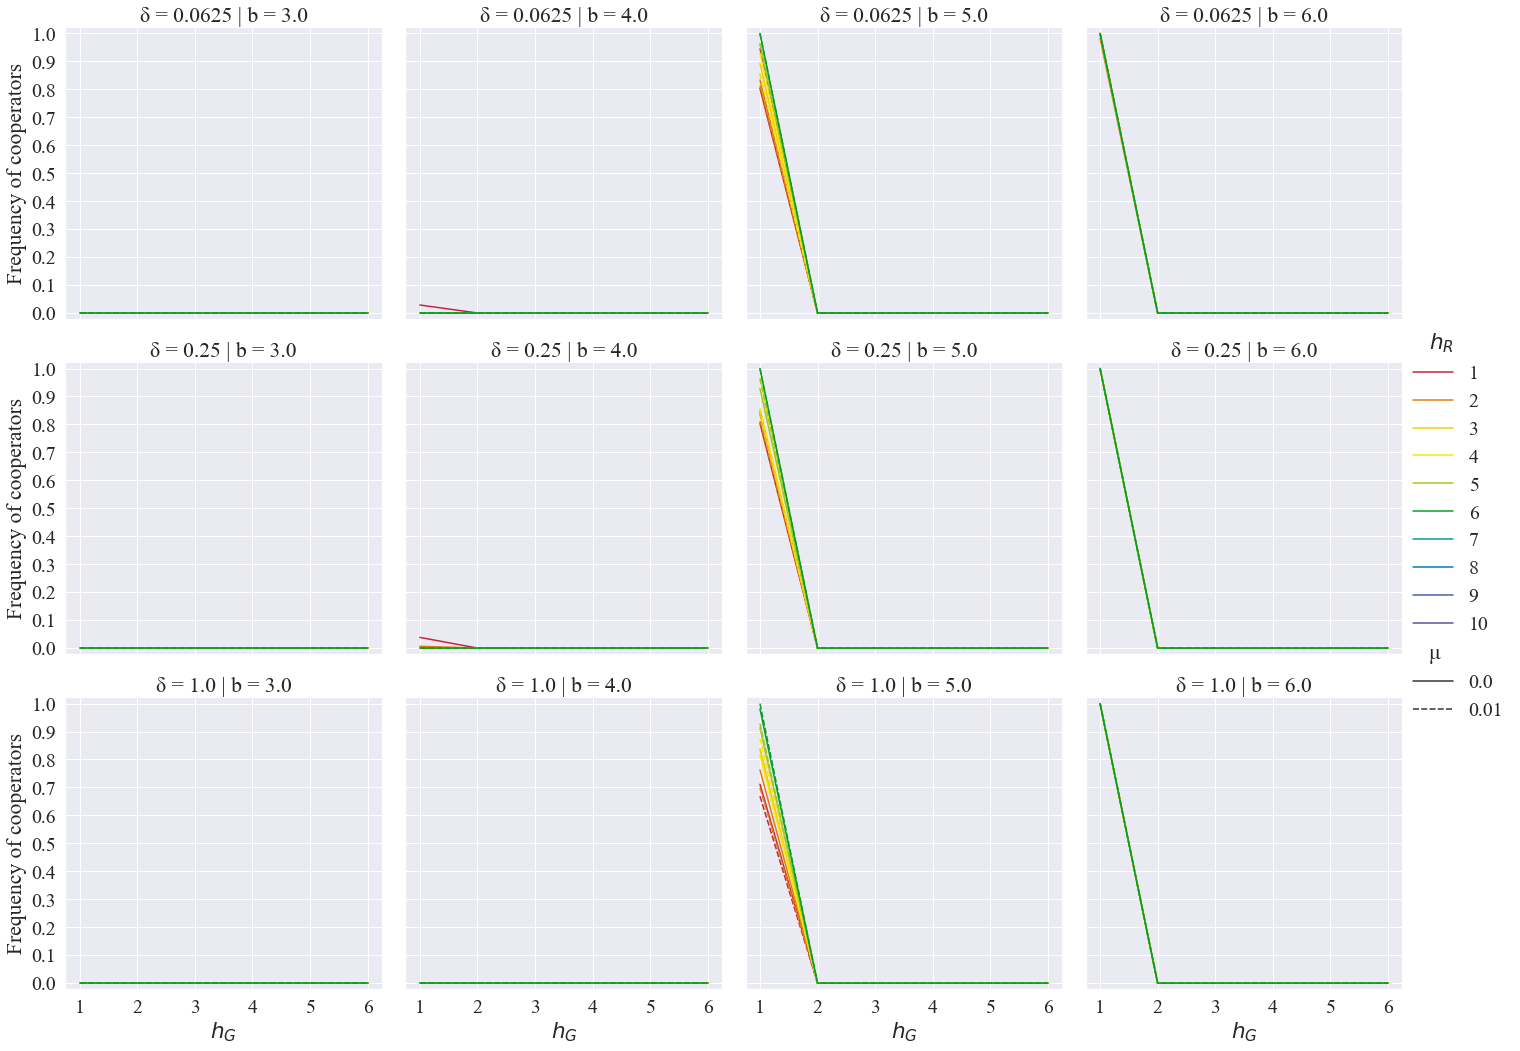

scale_free_4, Group, BD


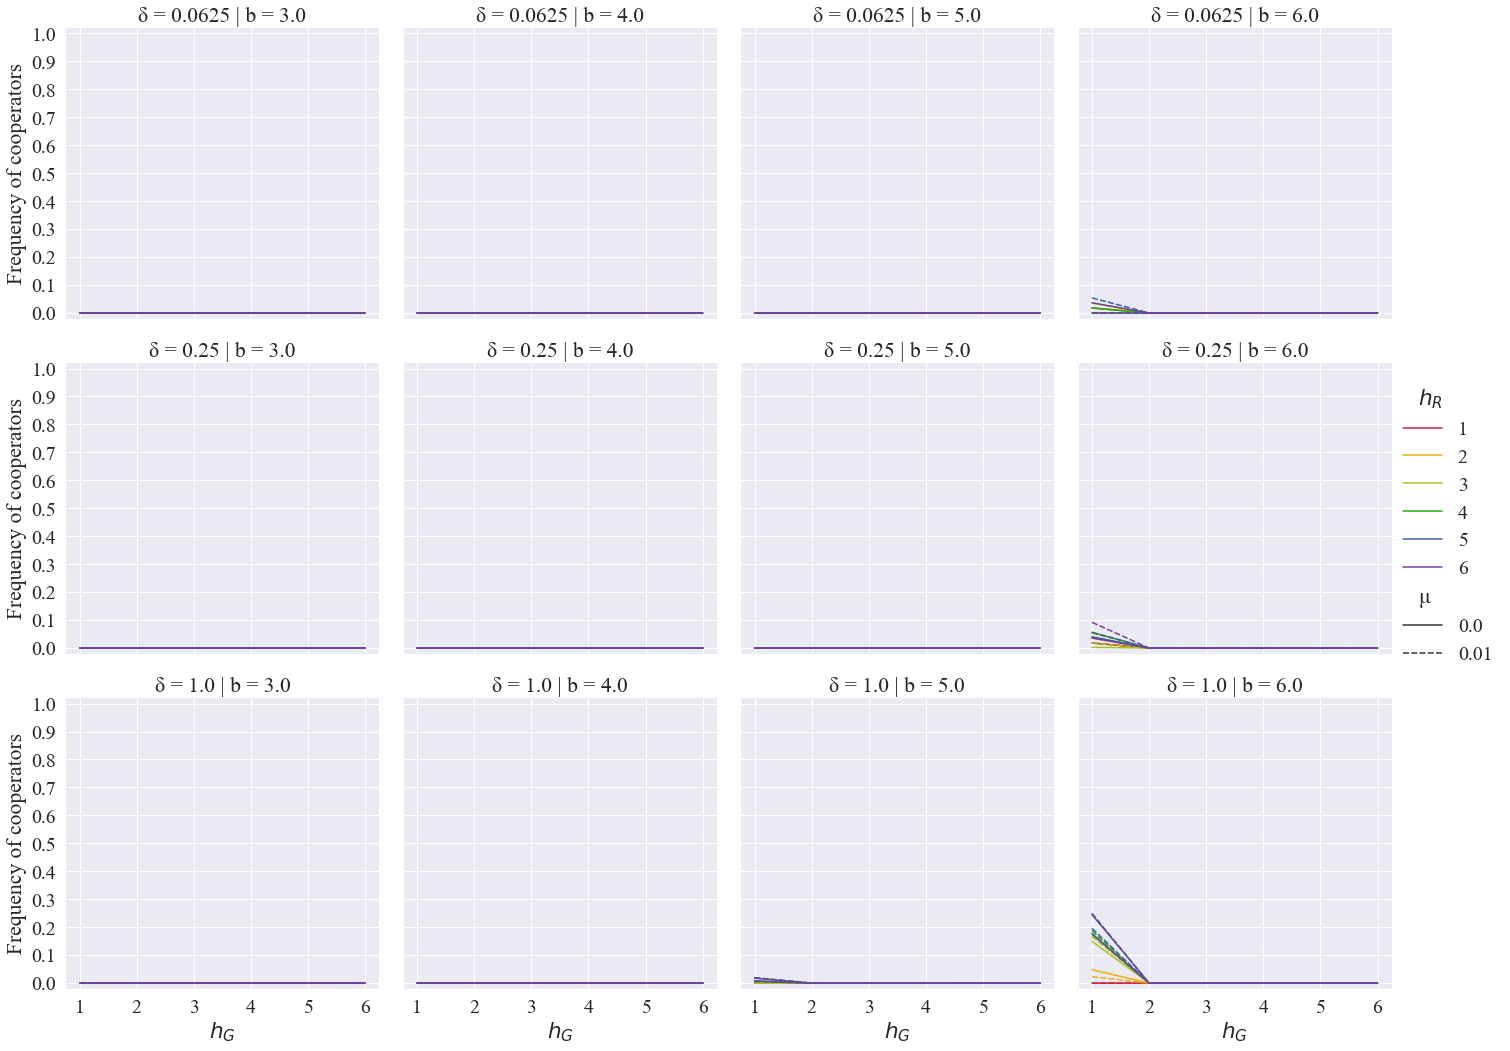

scale_free_4, Group, DB


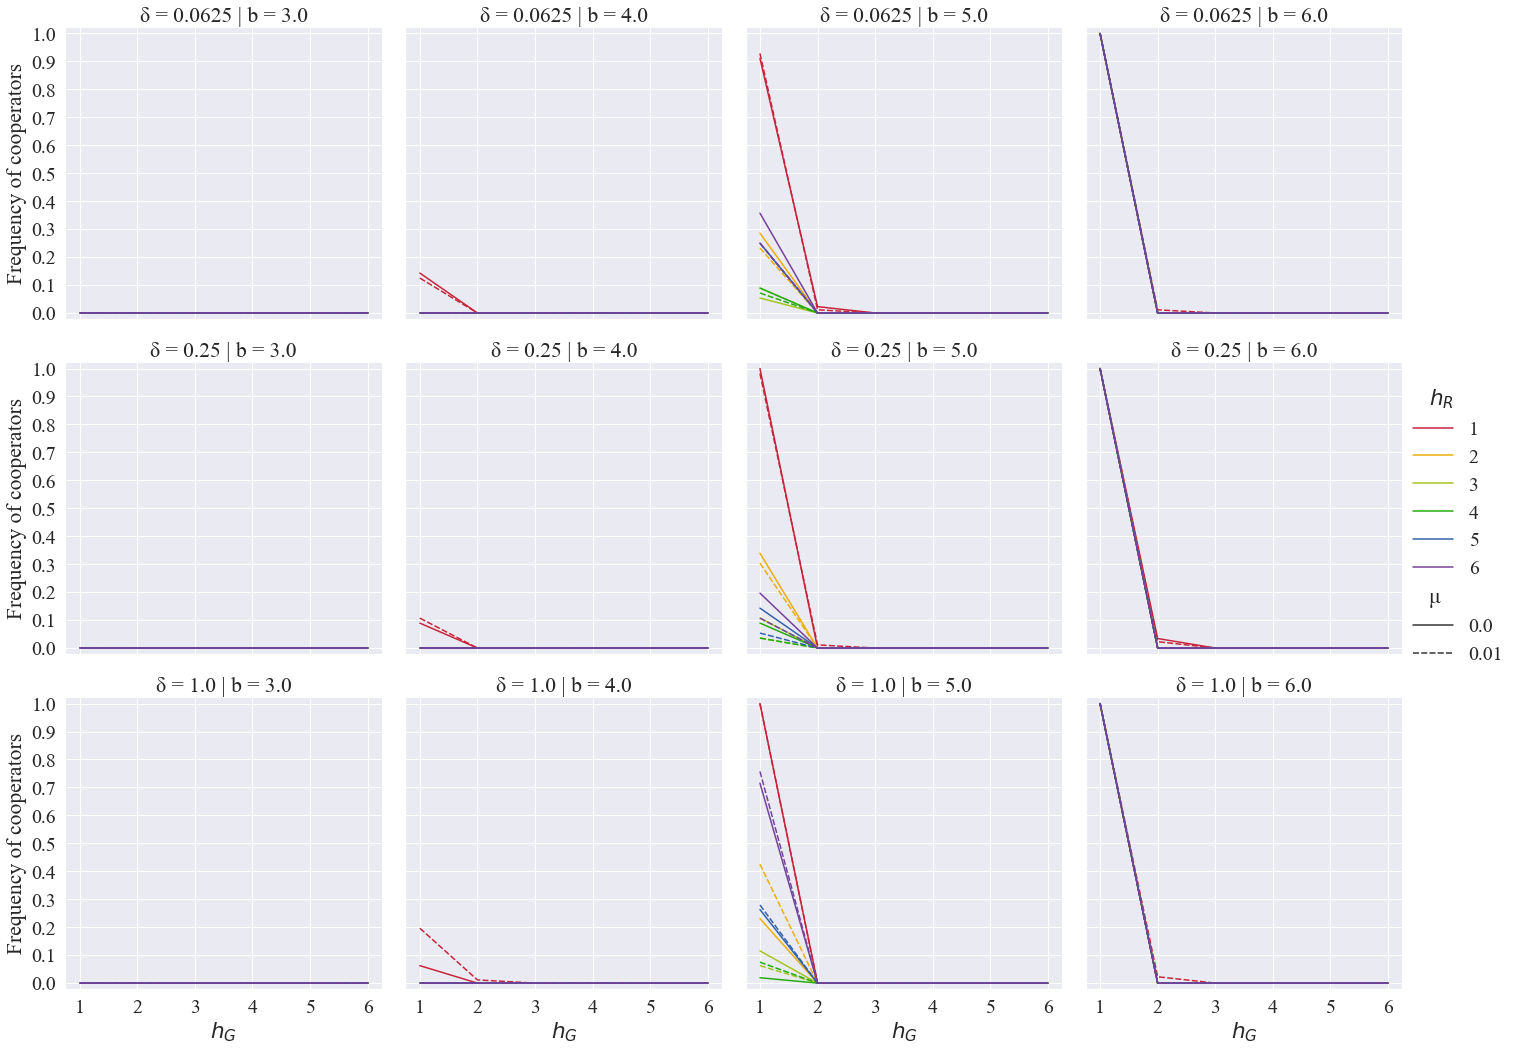

scale_free_4, Group, IM


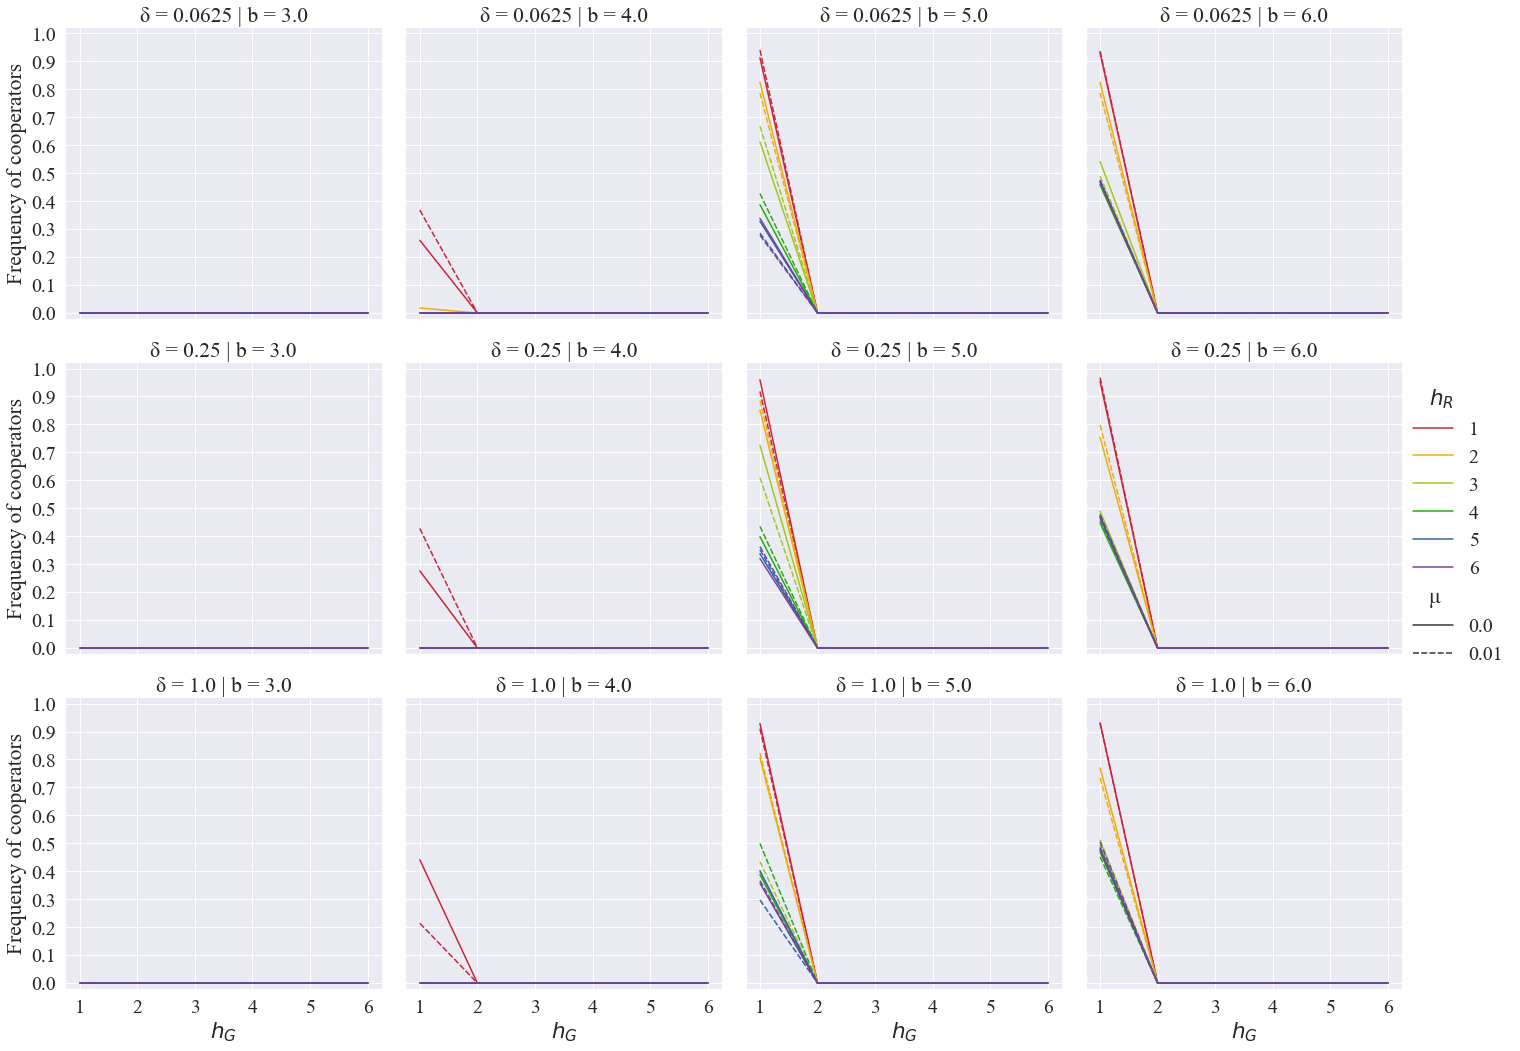

In [5]:
run(group_df, 'hG')

random_4, Group, BD


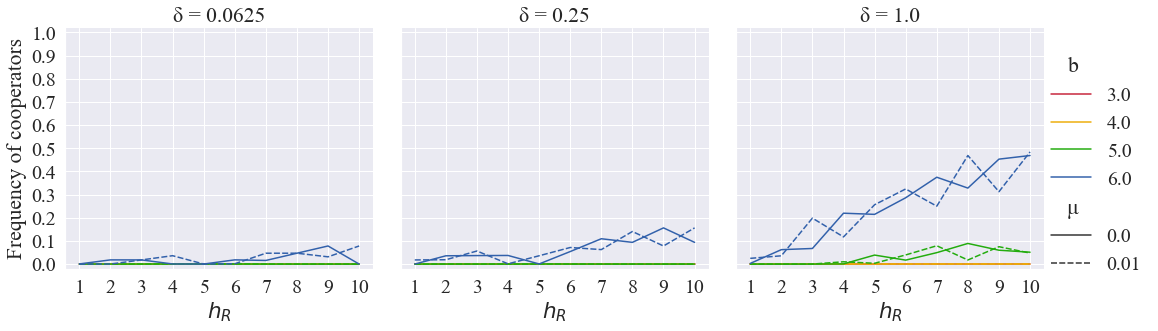

random_4, Group, DB


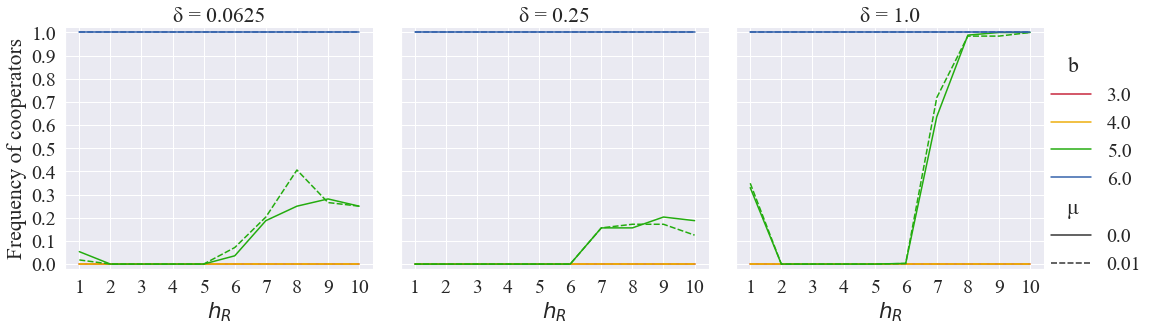

random_4, Group, IM


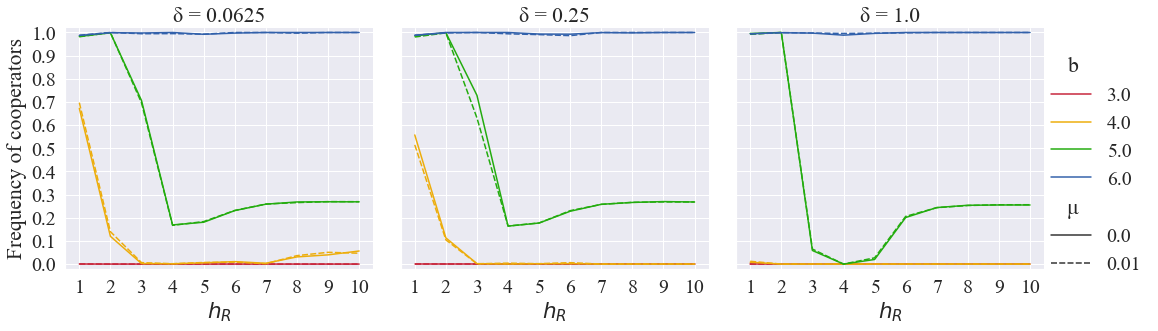

regular_4, Group, BD


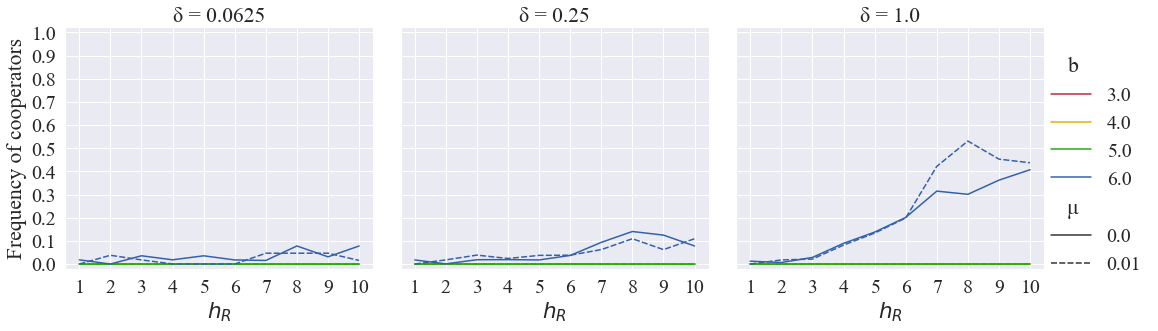

regular_4, Group, DB


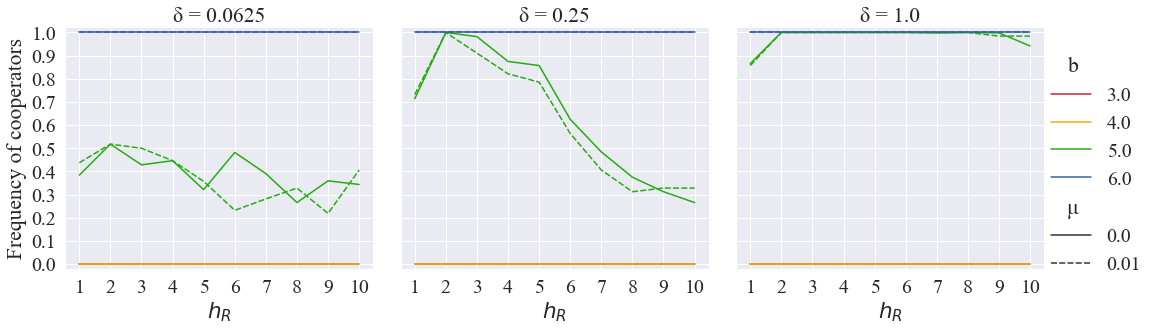

regular_4, Group, IM


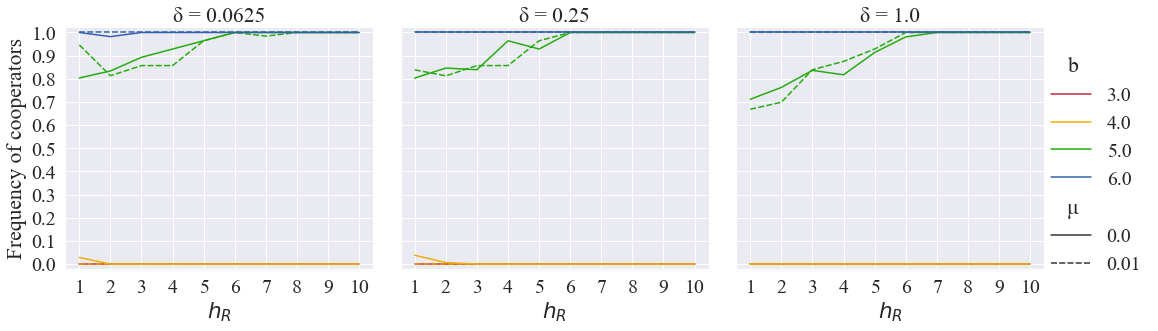

scale_free_4, Group, BD


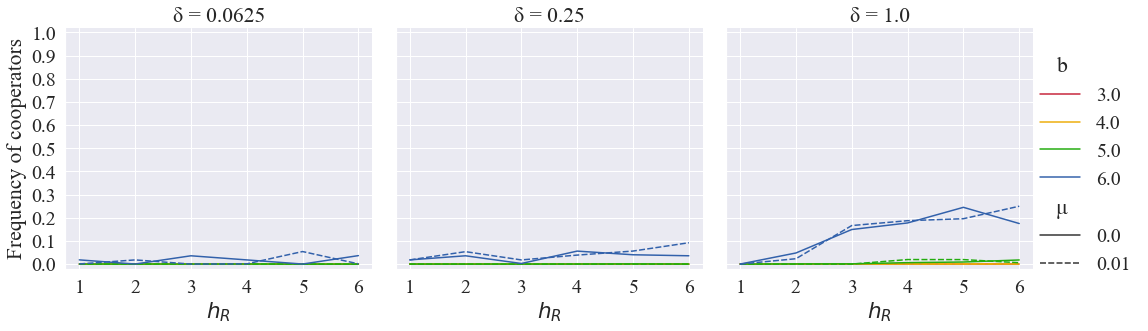

scale_free_4, Group, DB


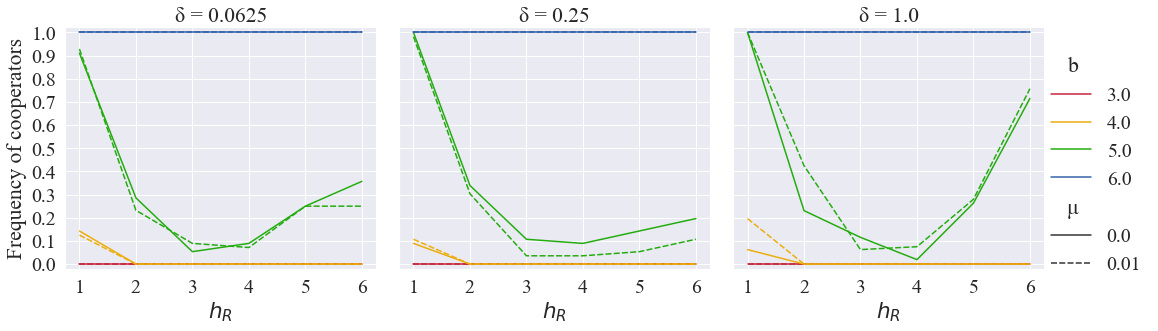

scale_free_4, Group, IM


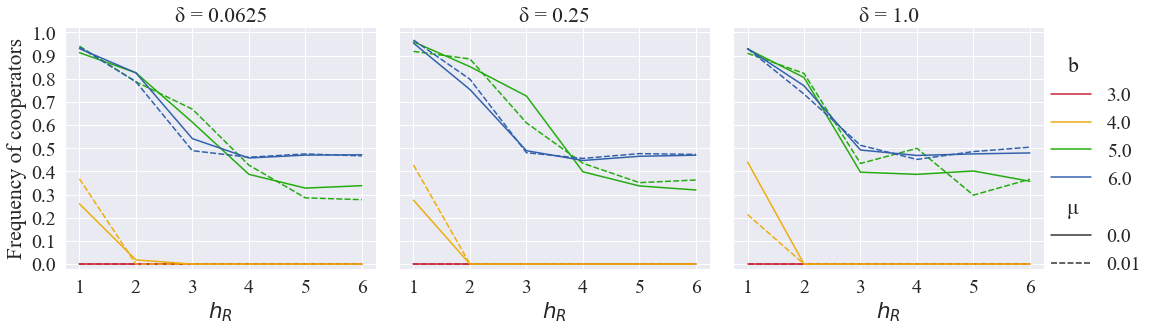

In [6]:
run(group_df, 'hR')

random_4, PairWise, BD


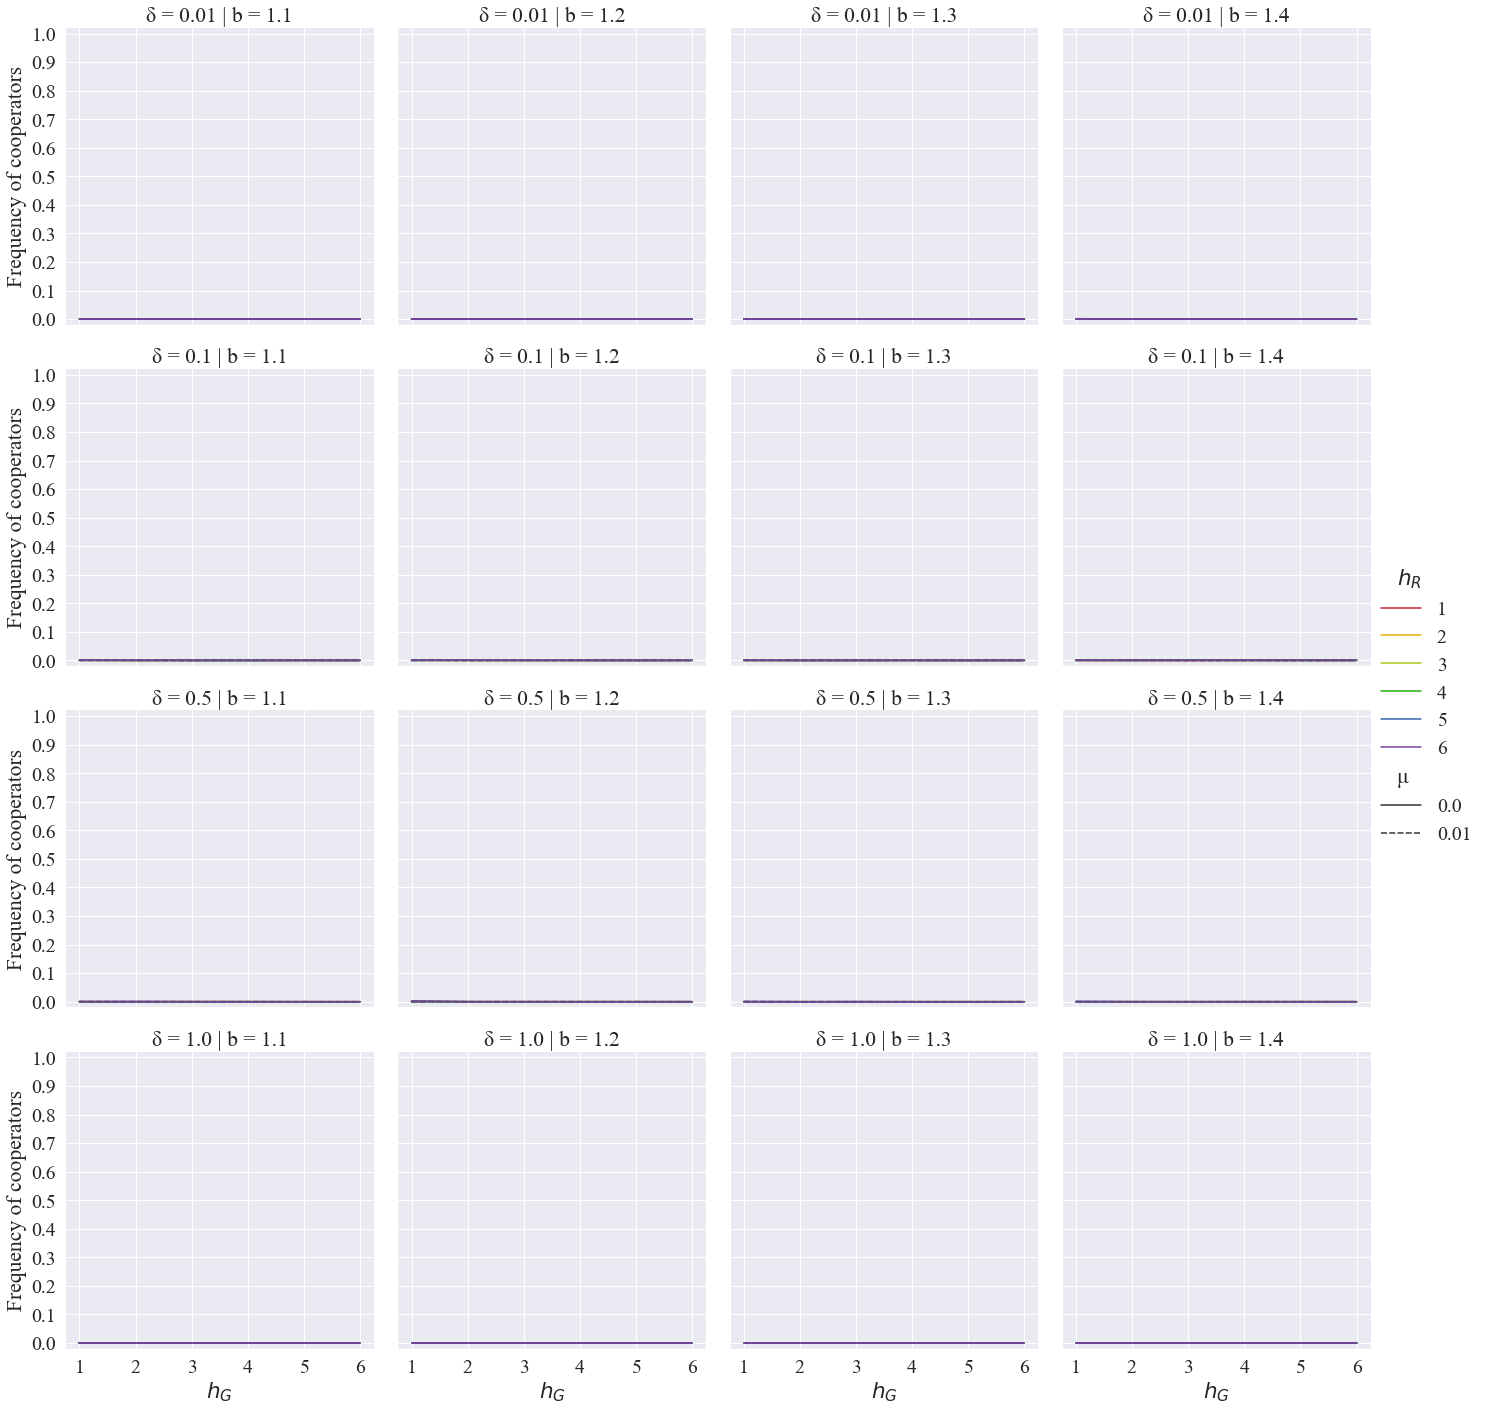

random_4, PairWise, DB


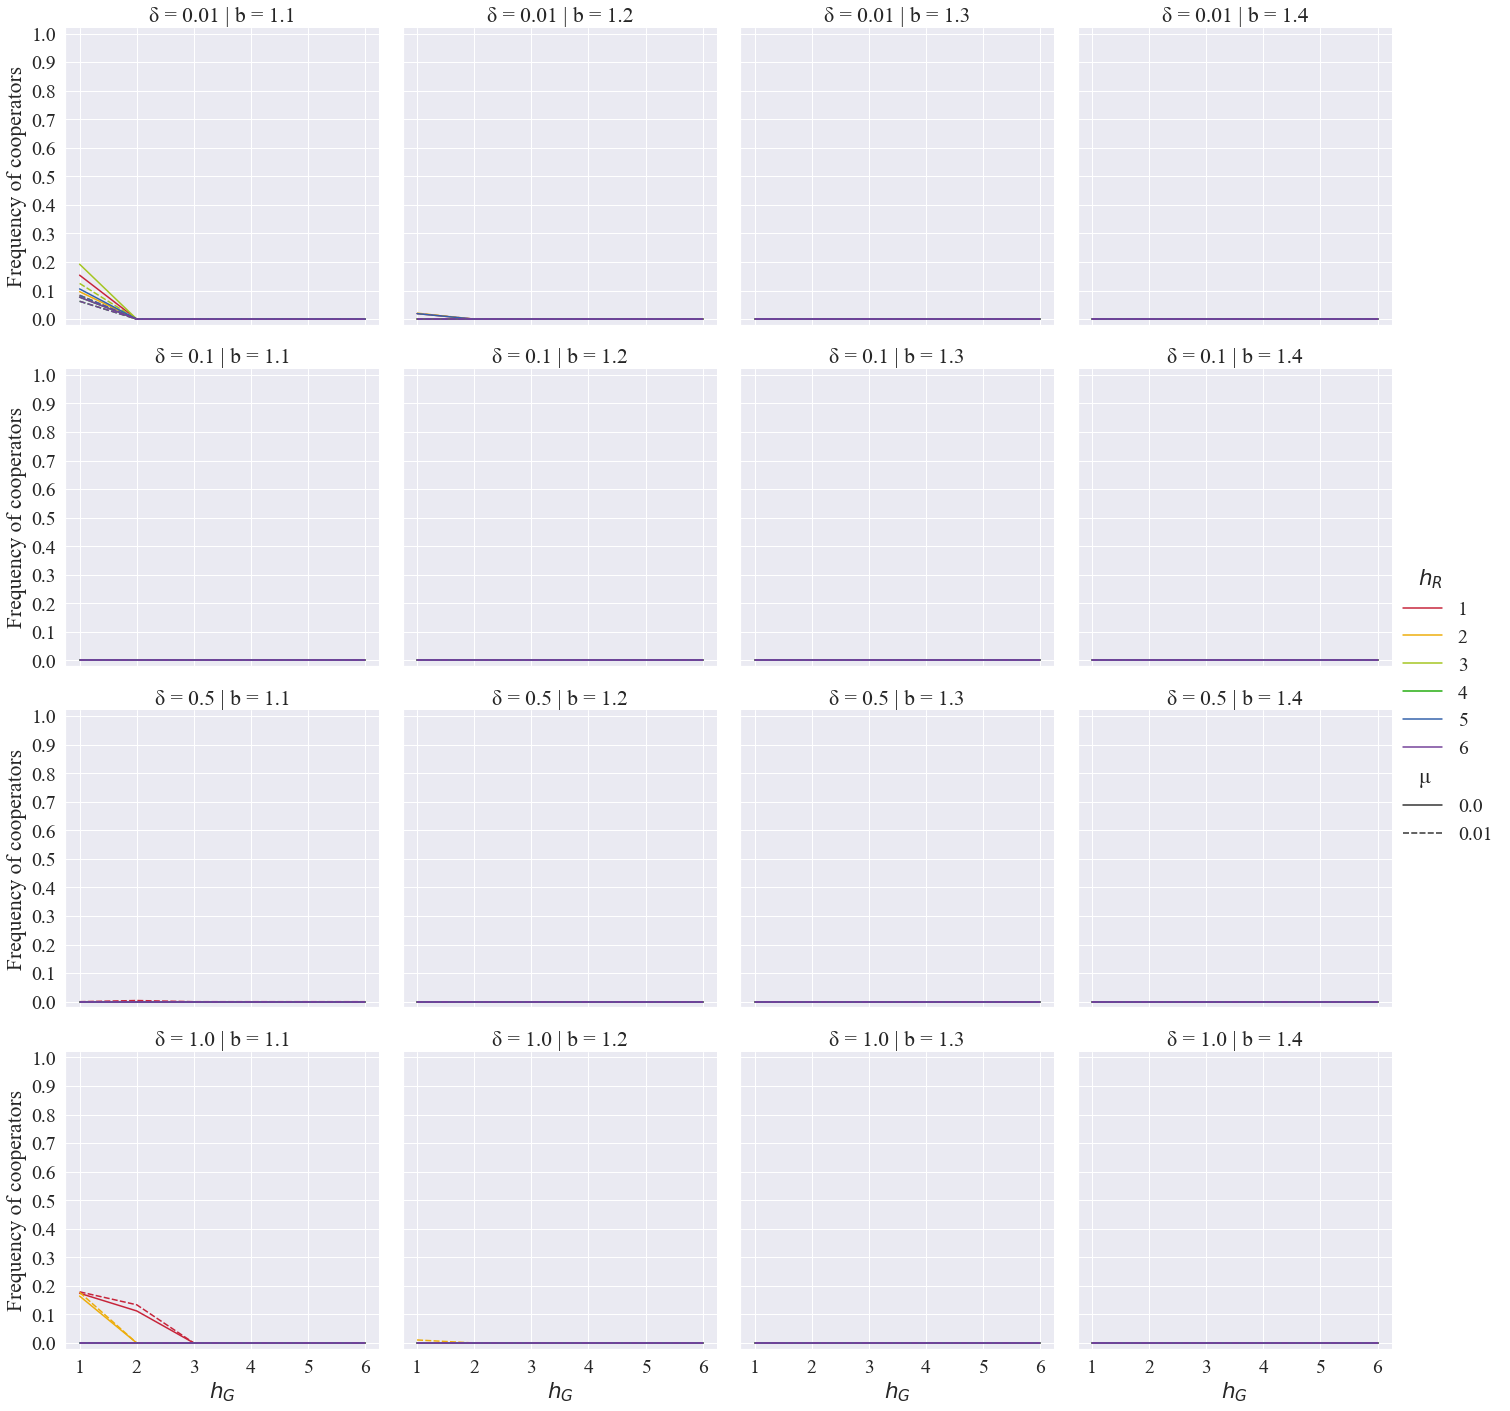

random_4, PairWise, IM


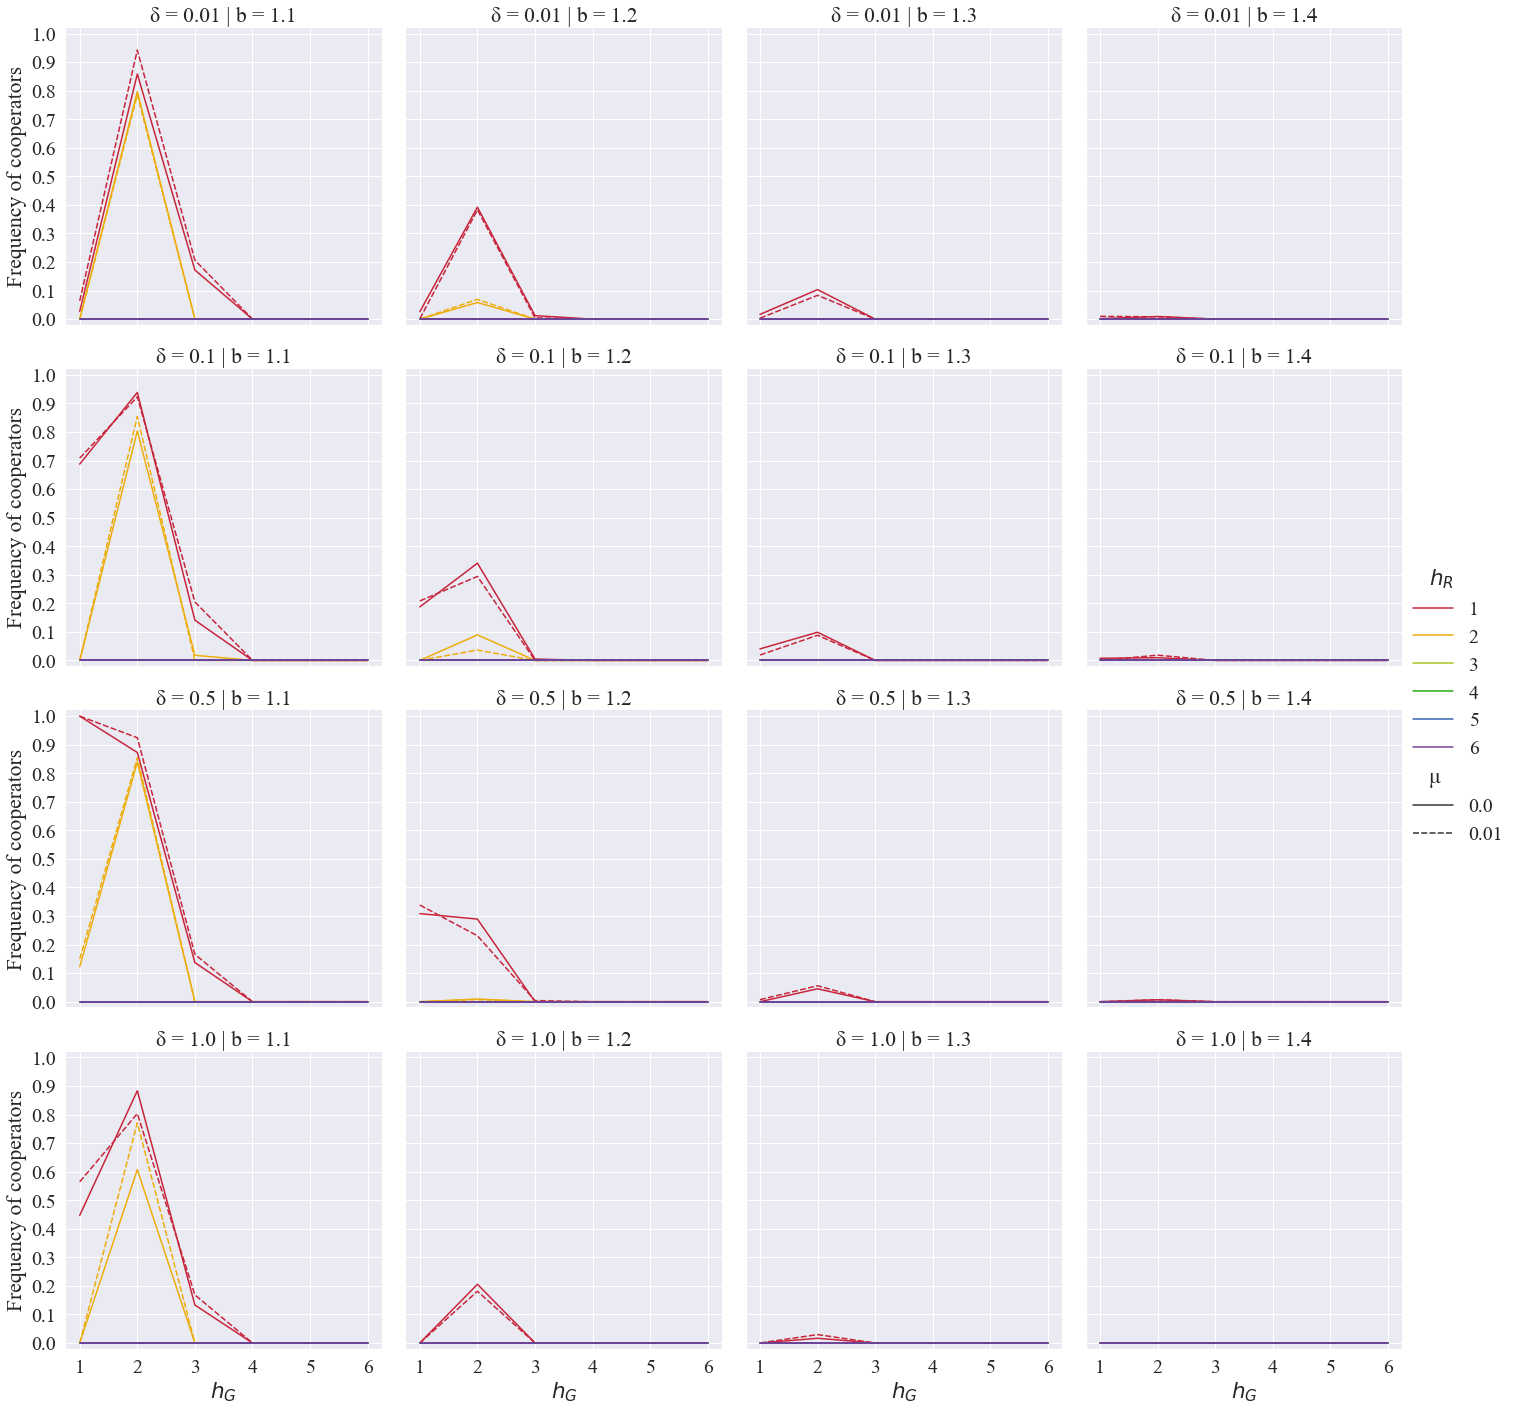

regular_4, PairWise, BD


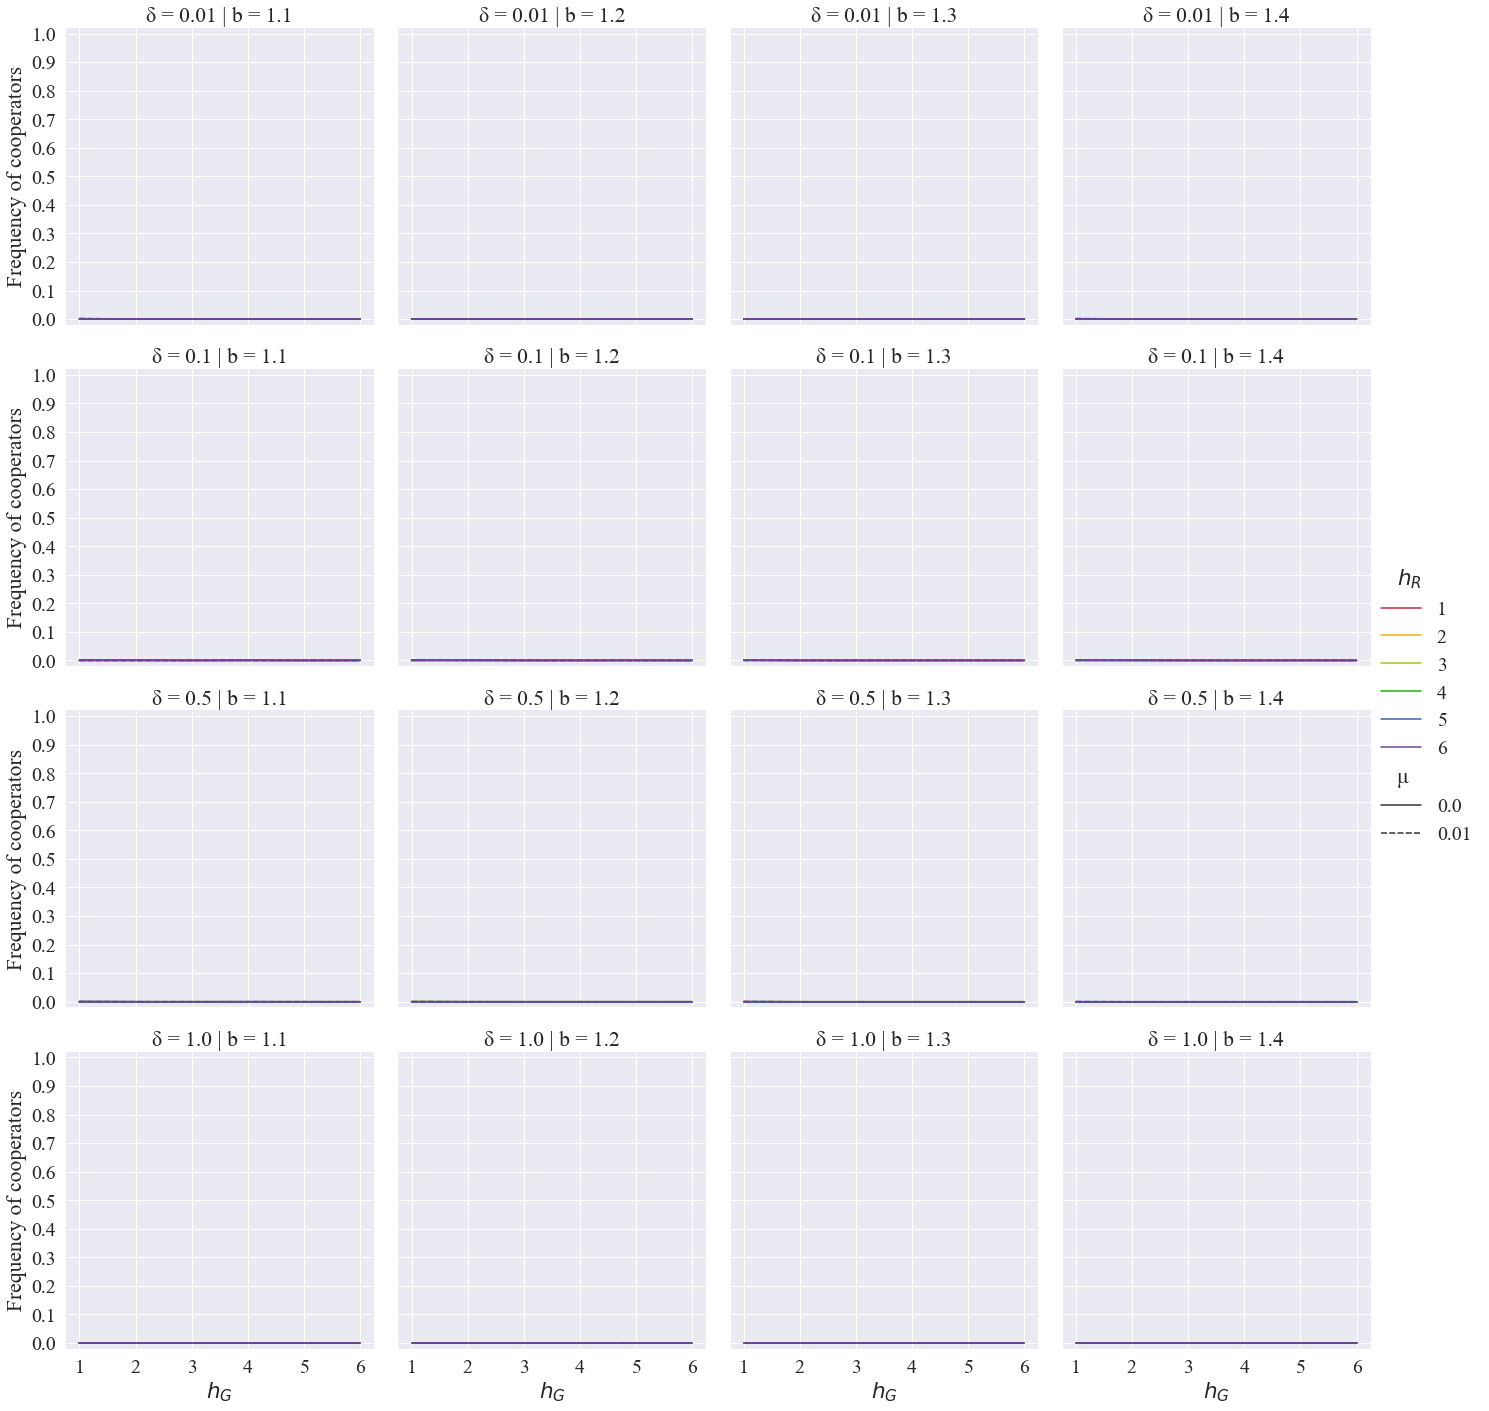

regular_4, PairWise, DB


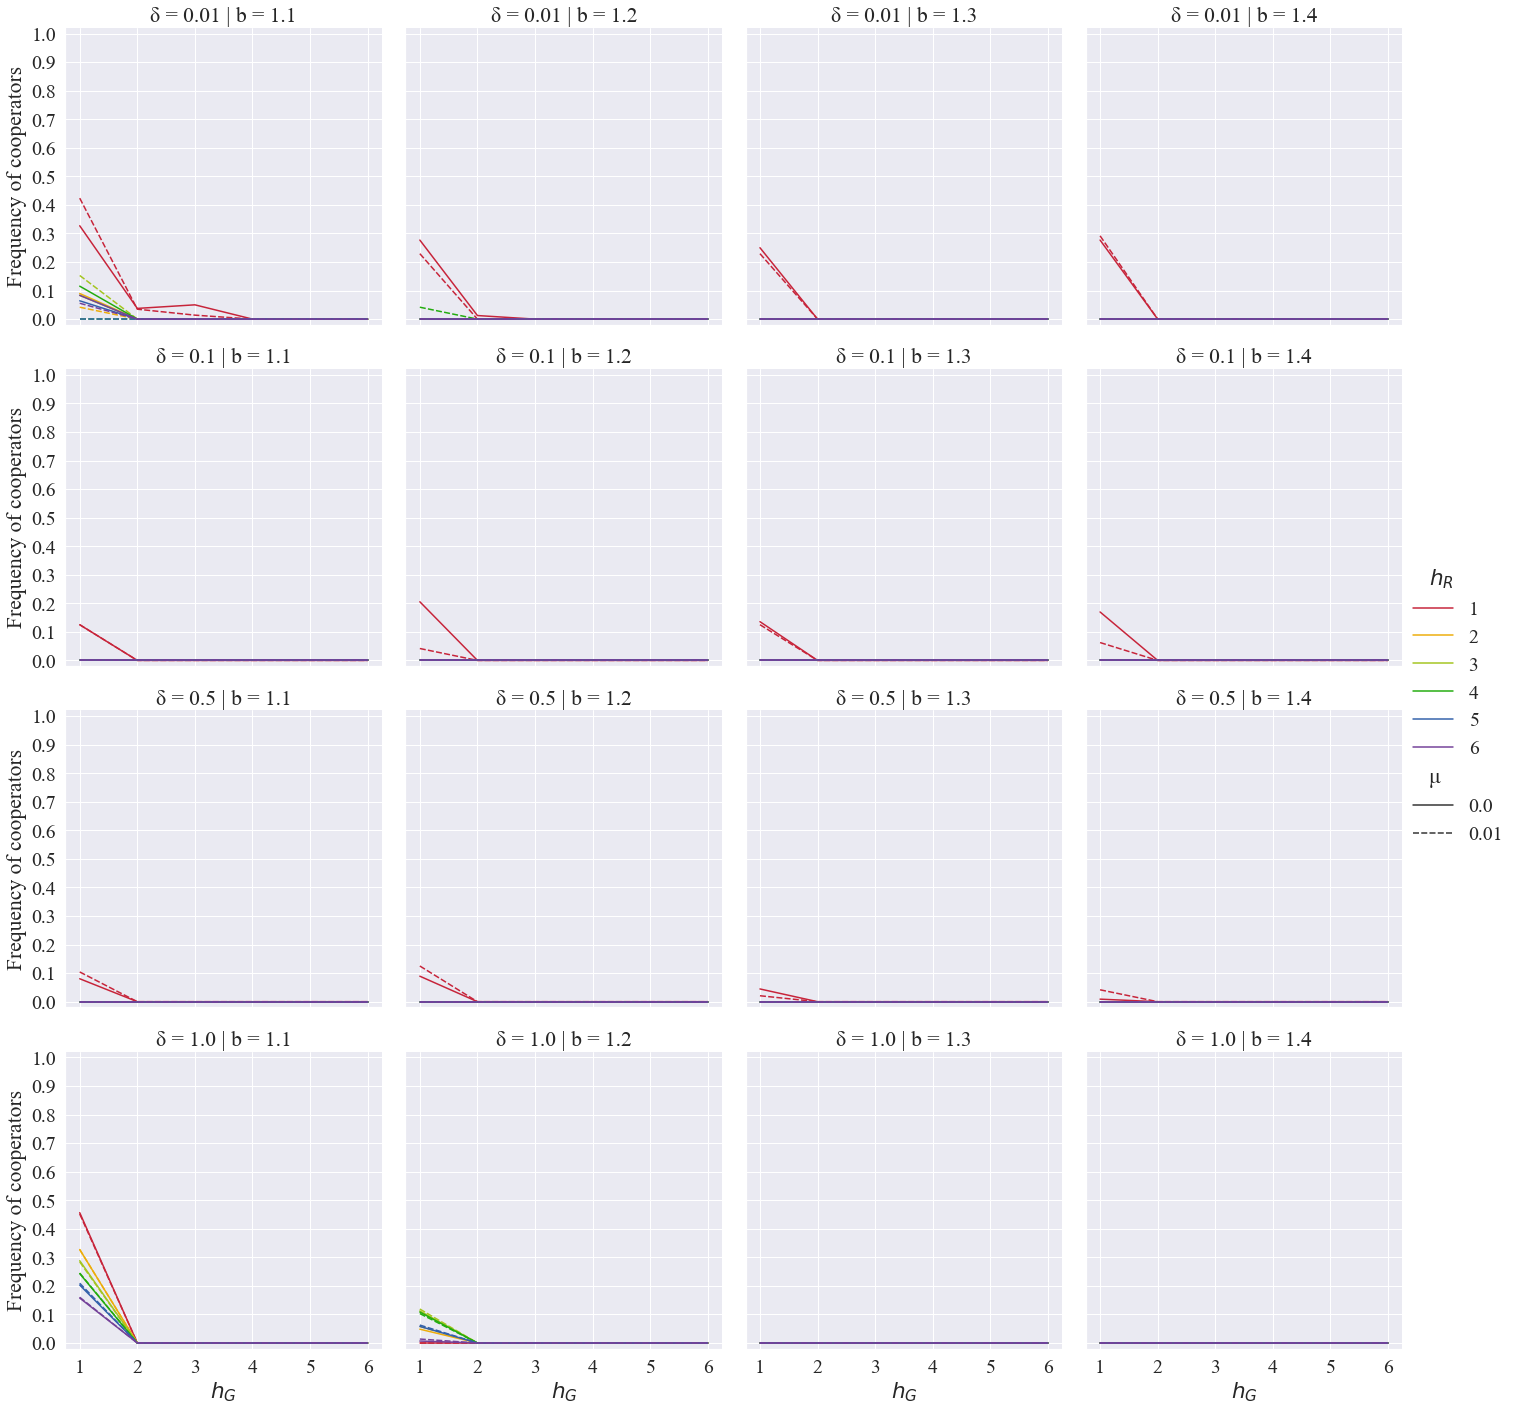

regular_4, PairWise, IM


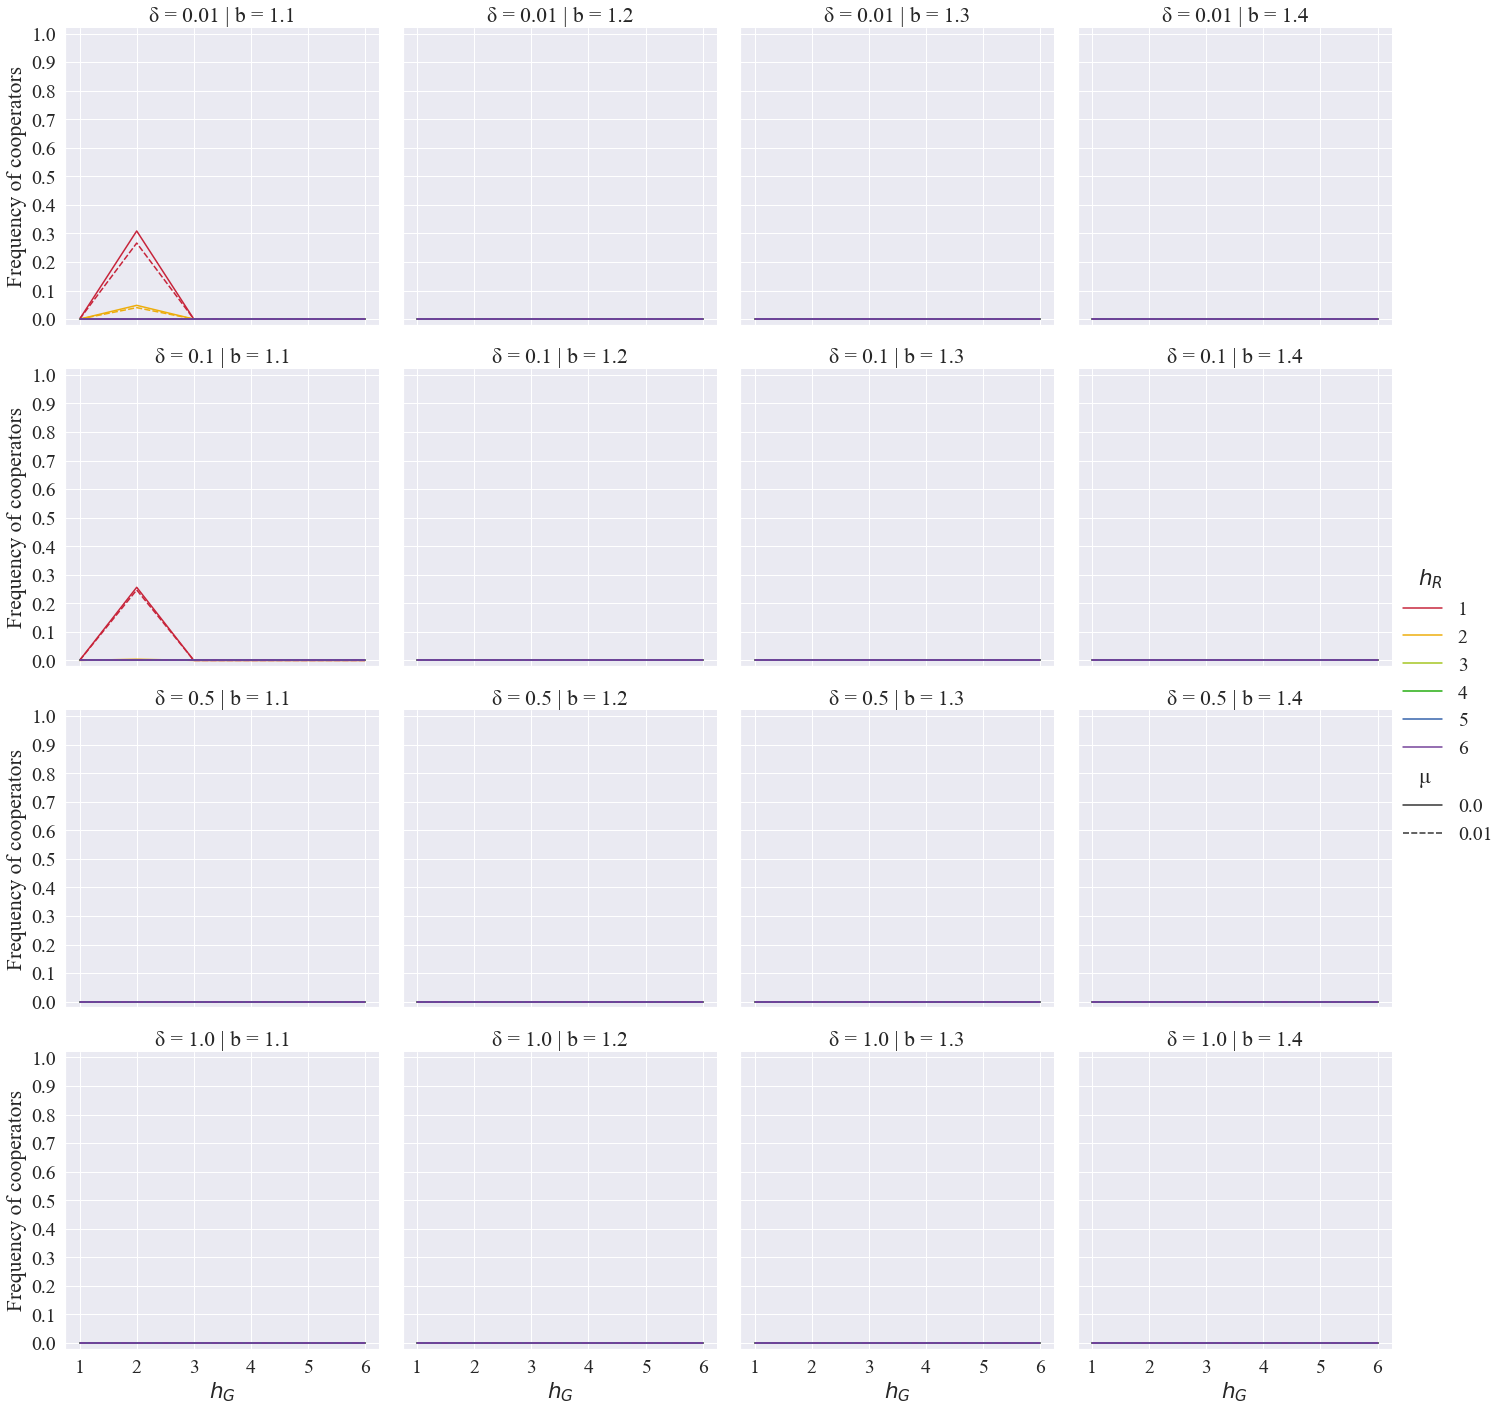

scale_free_4, PairWise, BD


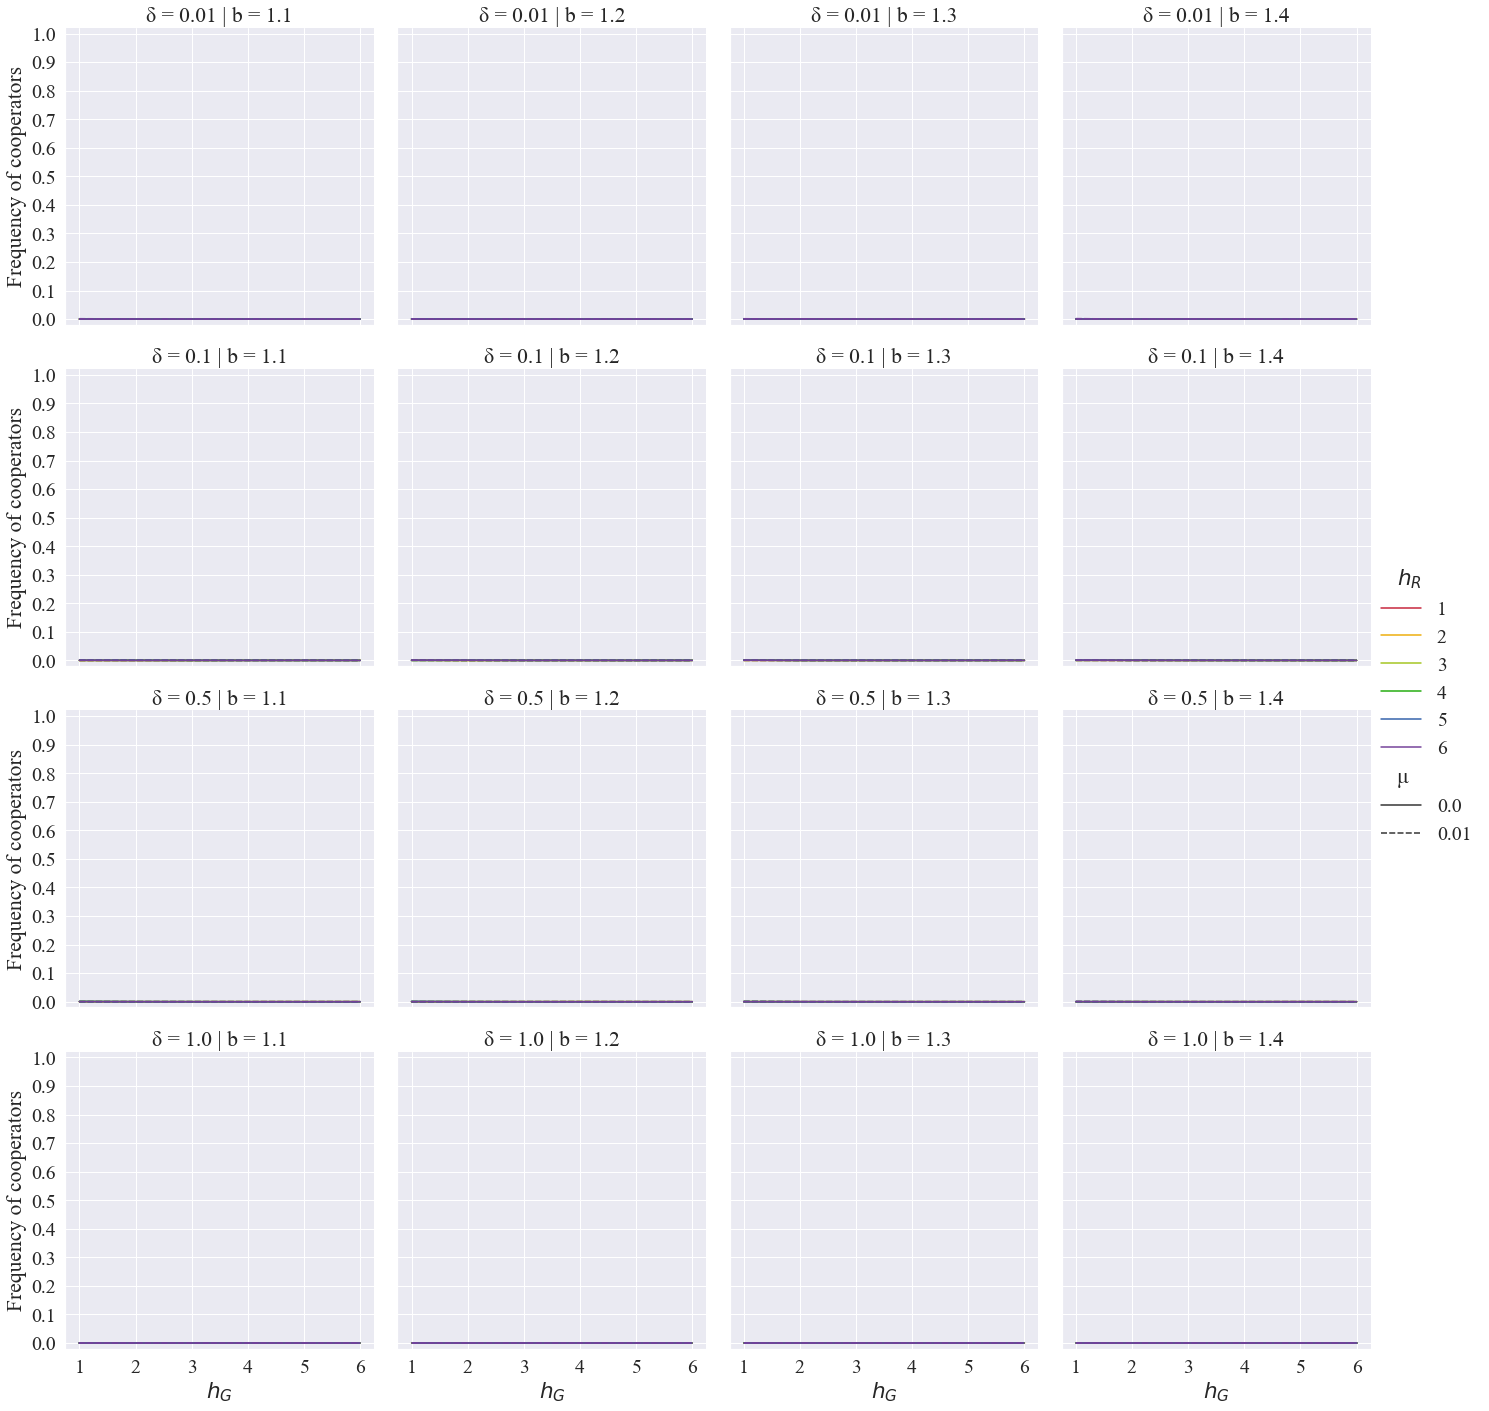

scale_free_4, PairWise, DB


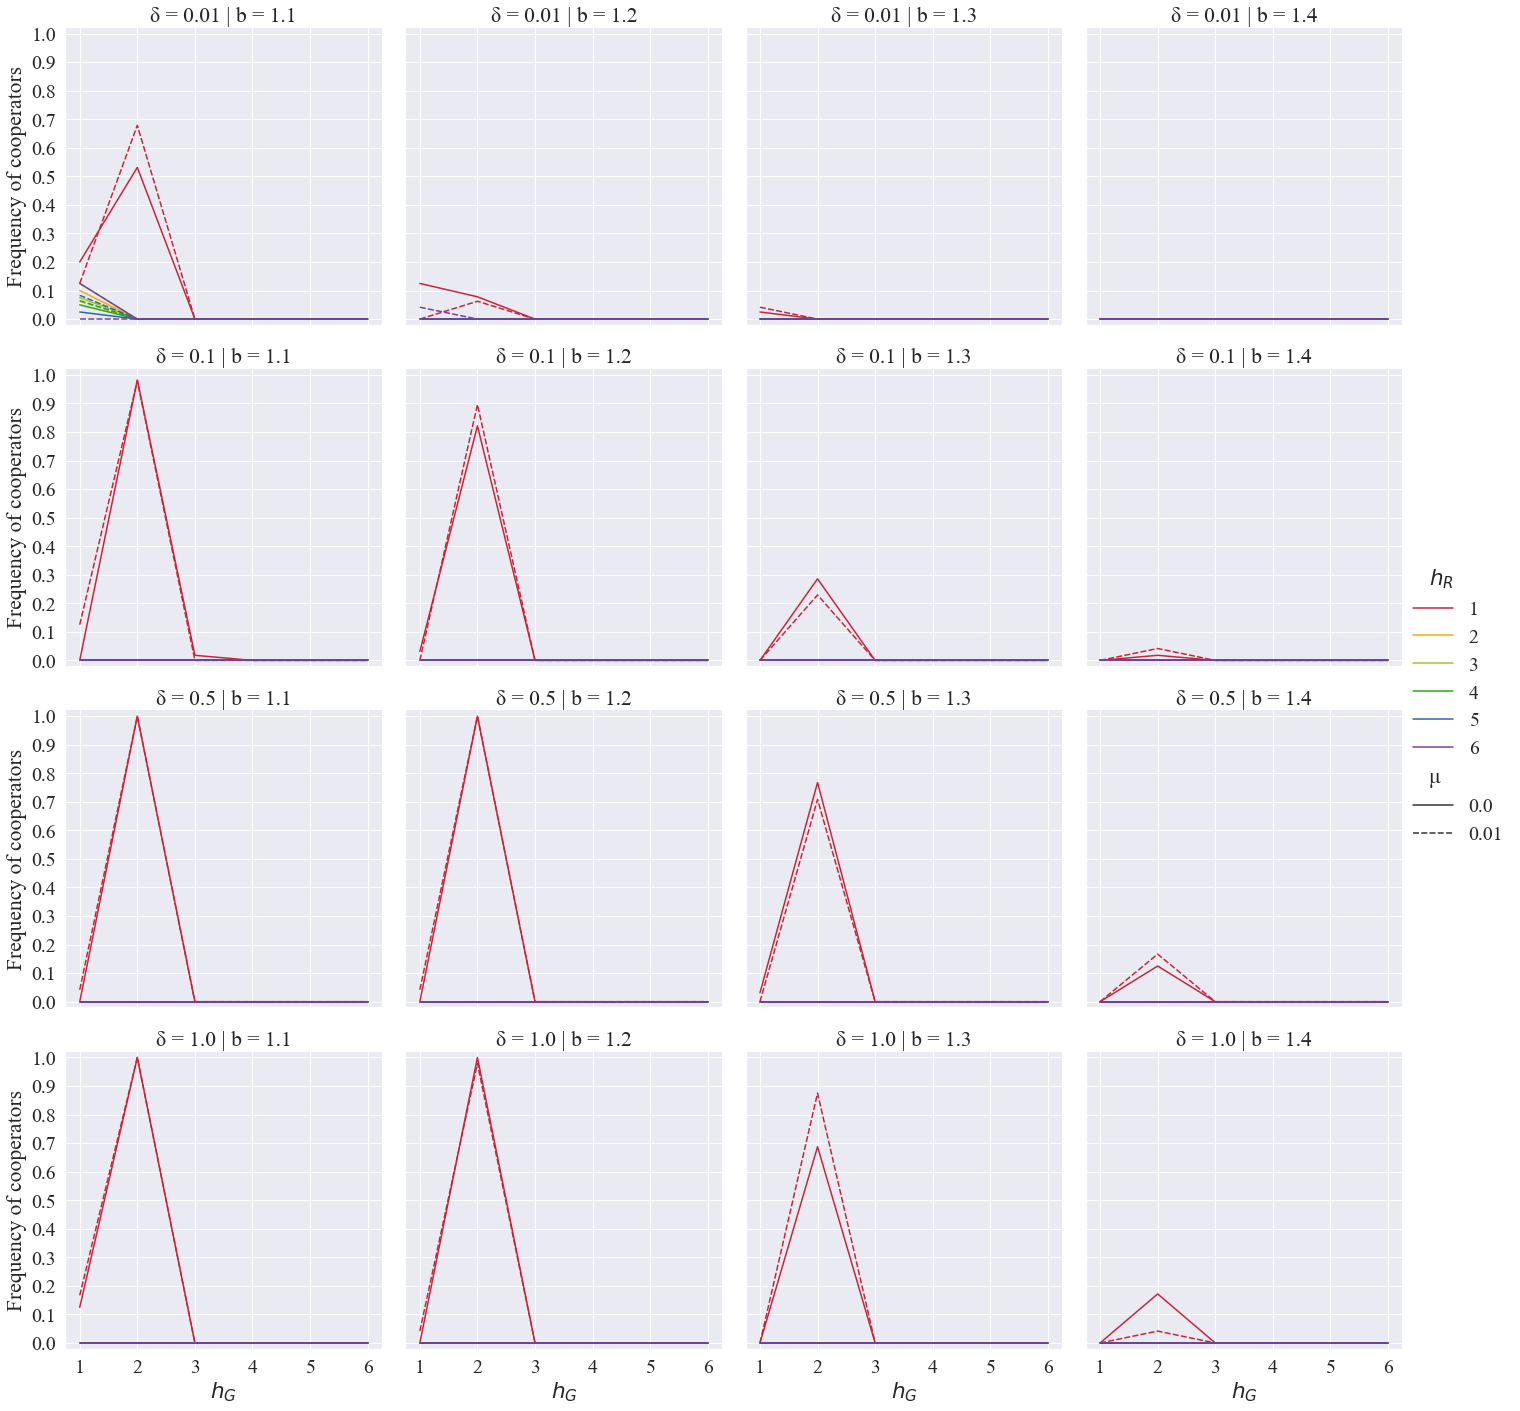

scale_free_4, PairWise, IM


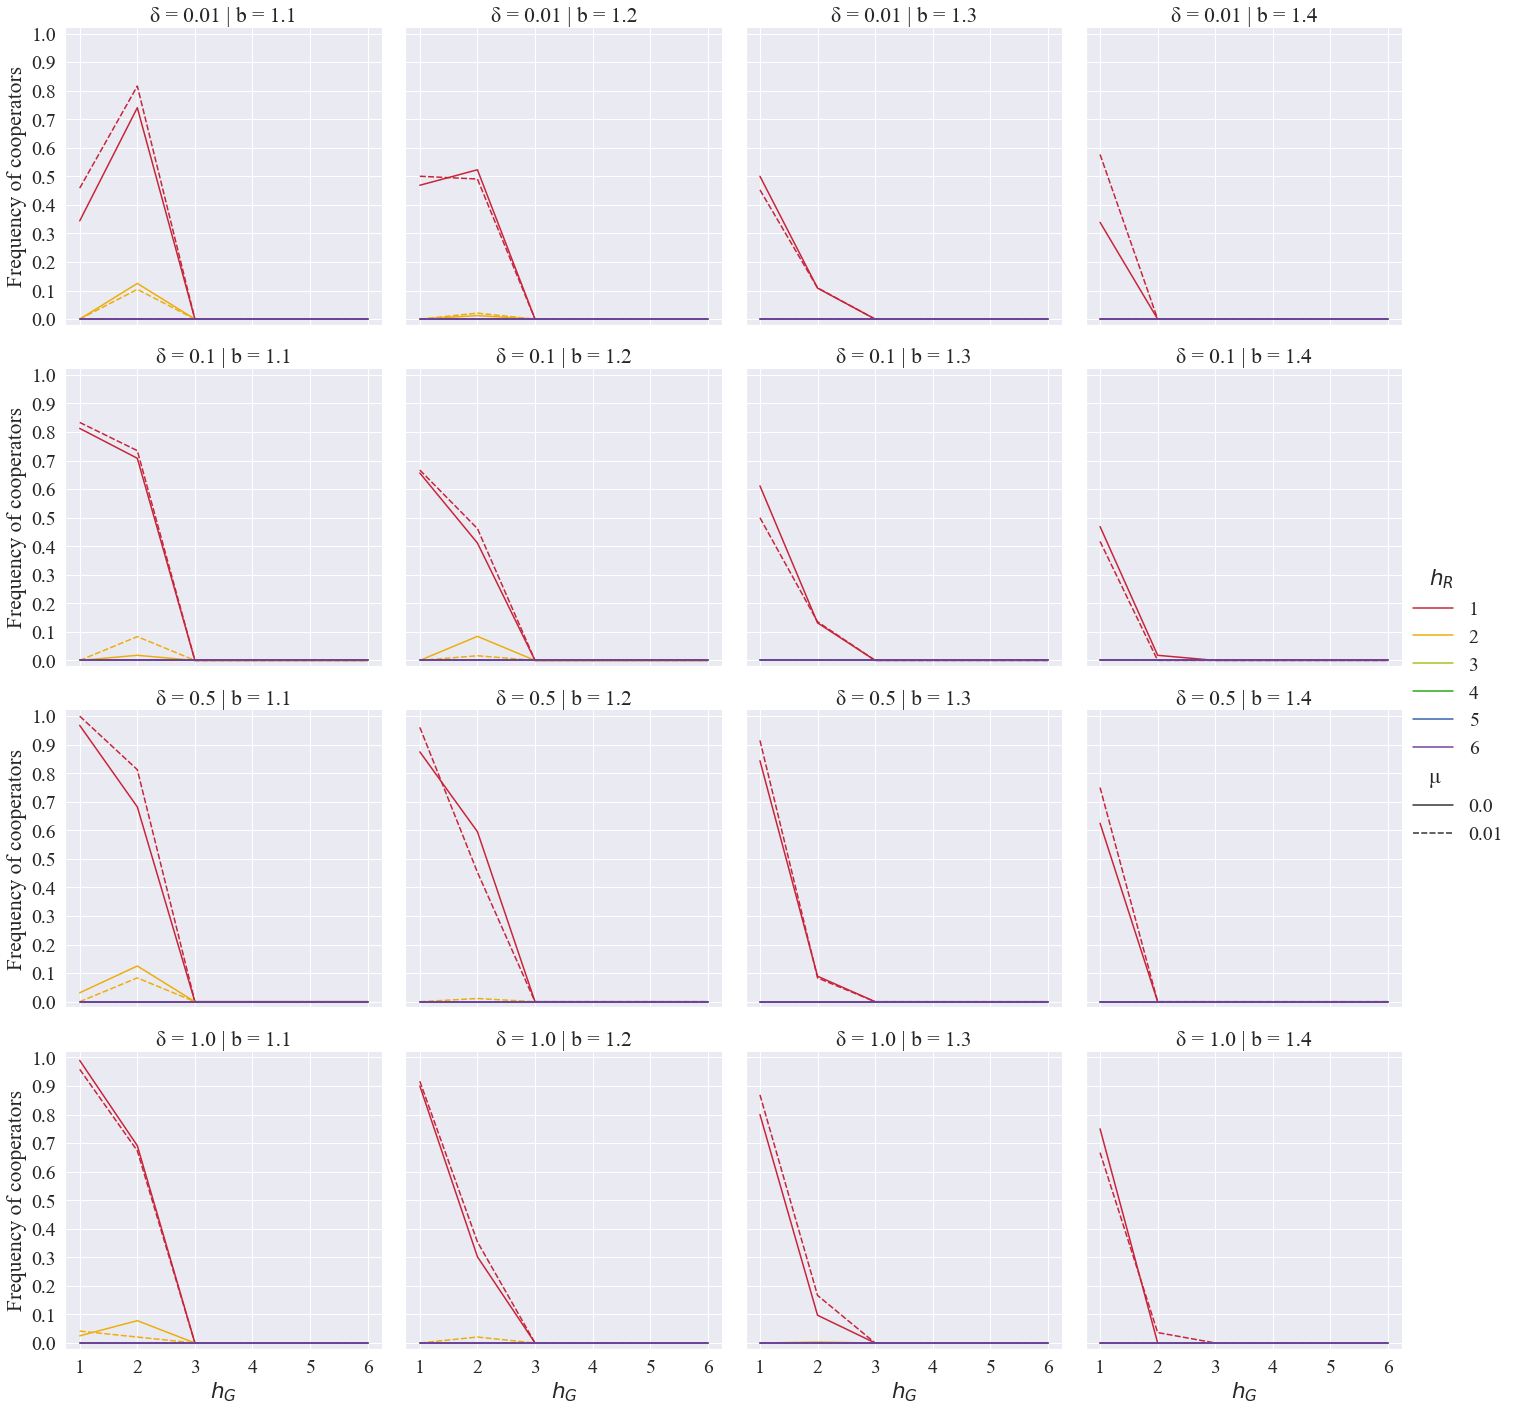

In [7]:
run(pair_df, 'hG')

random_4, PairWise, BD


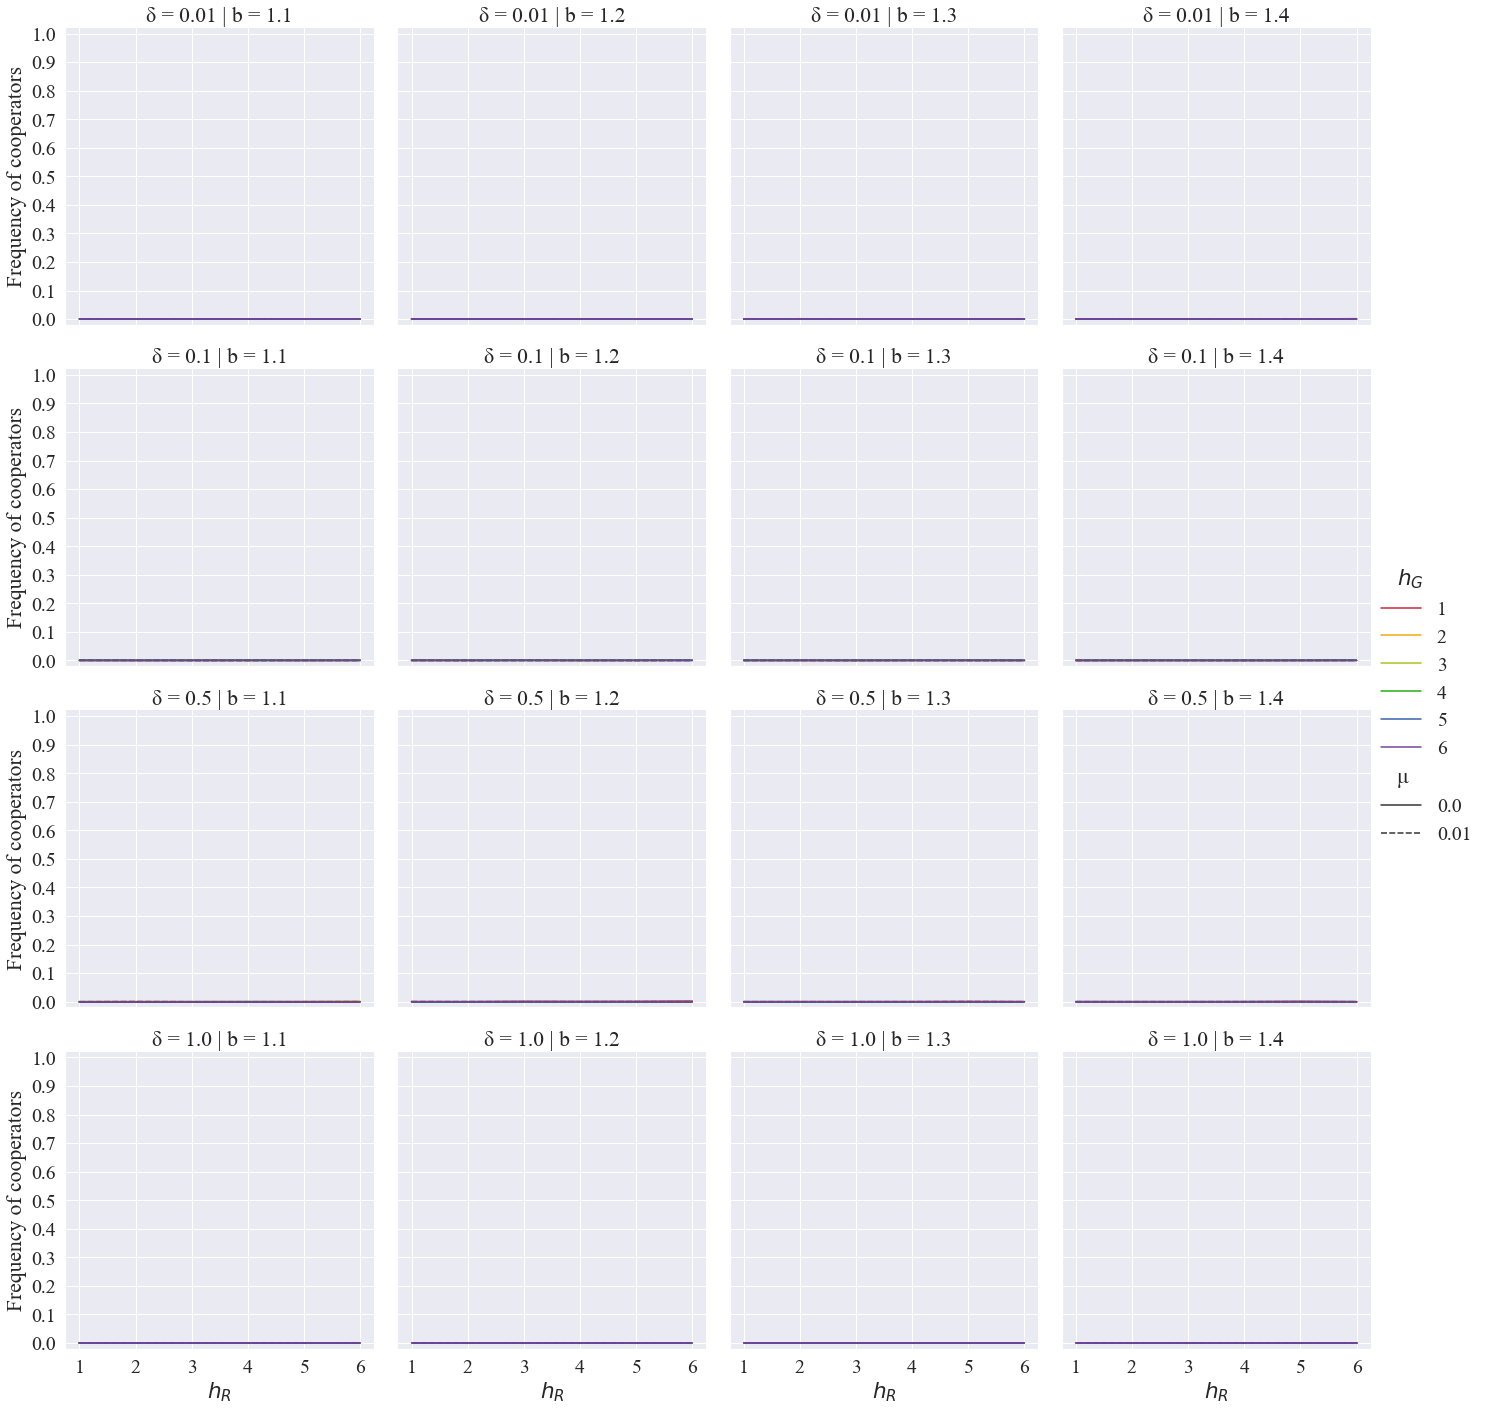

random_4, PairWise, DB


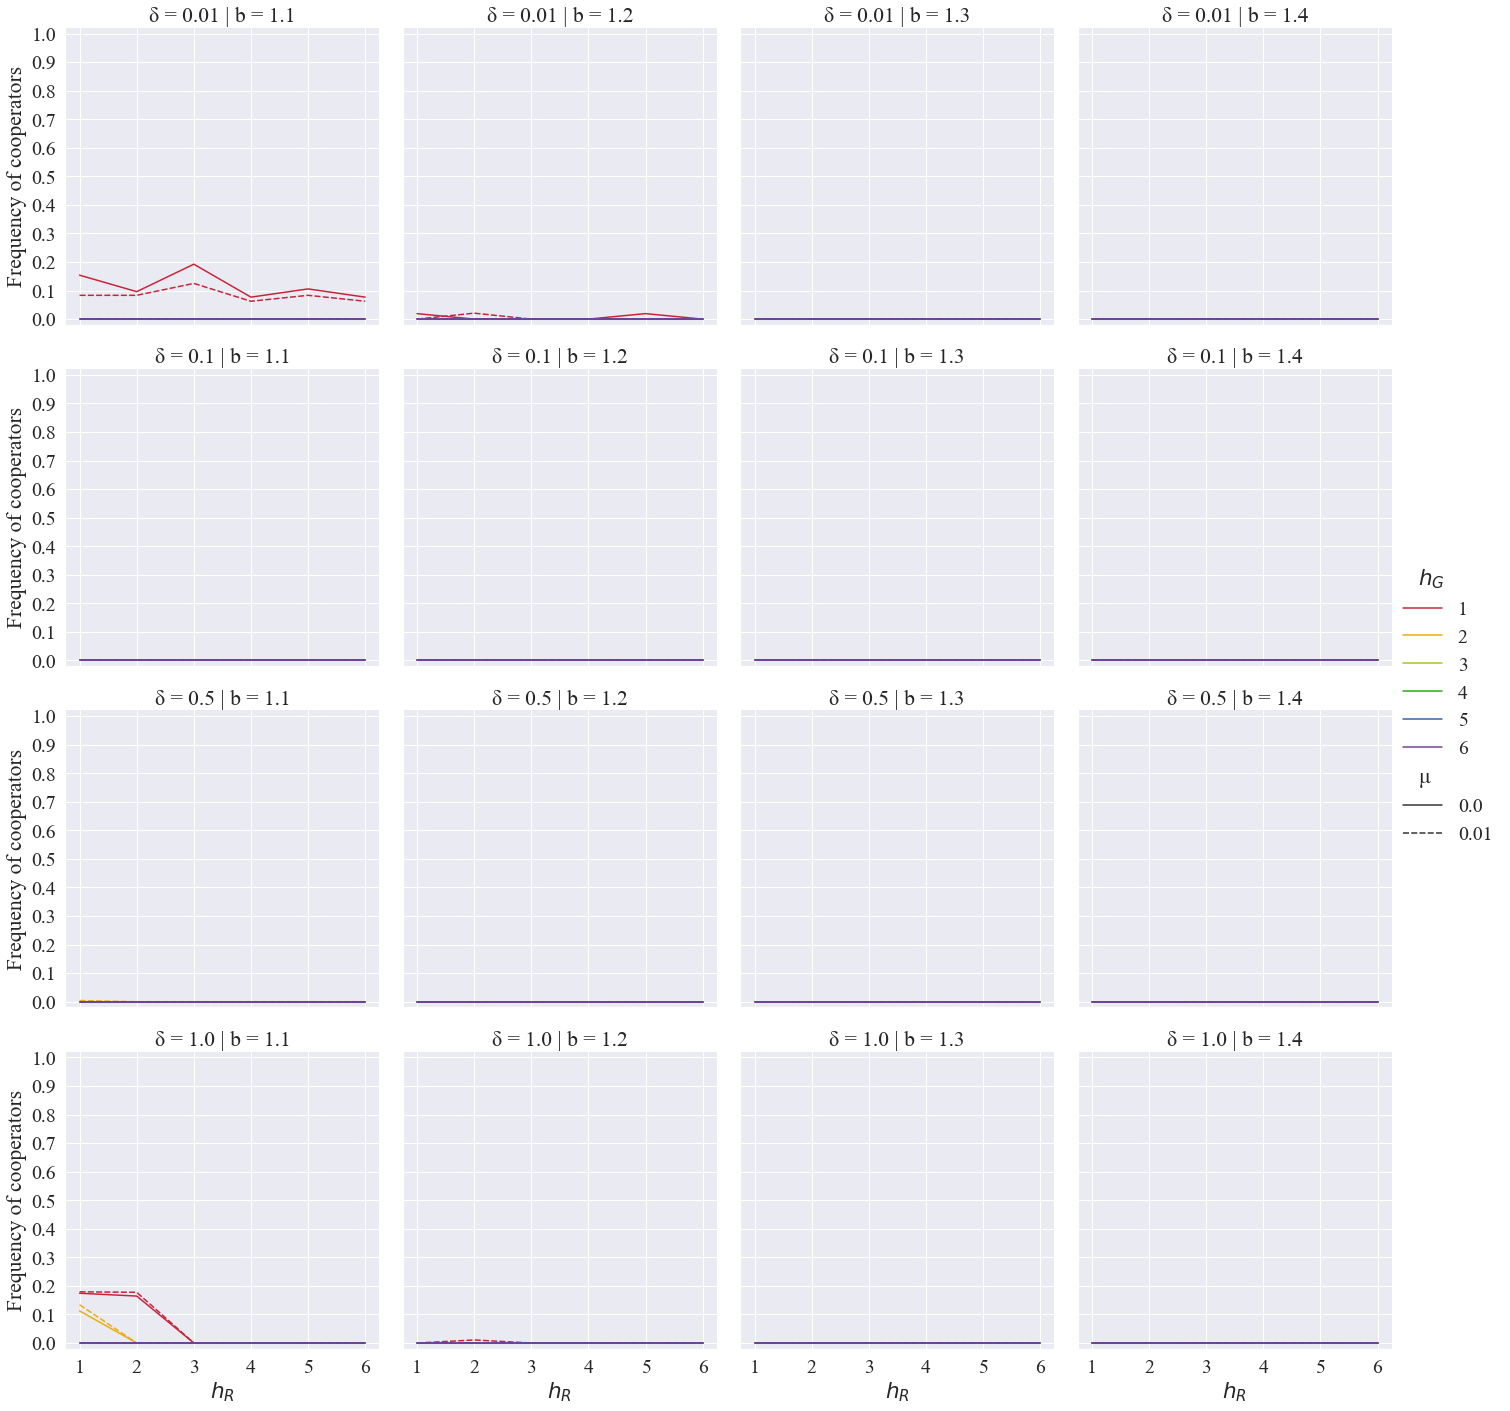

random_4, PairWise, IM


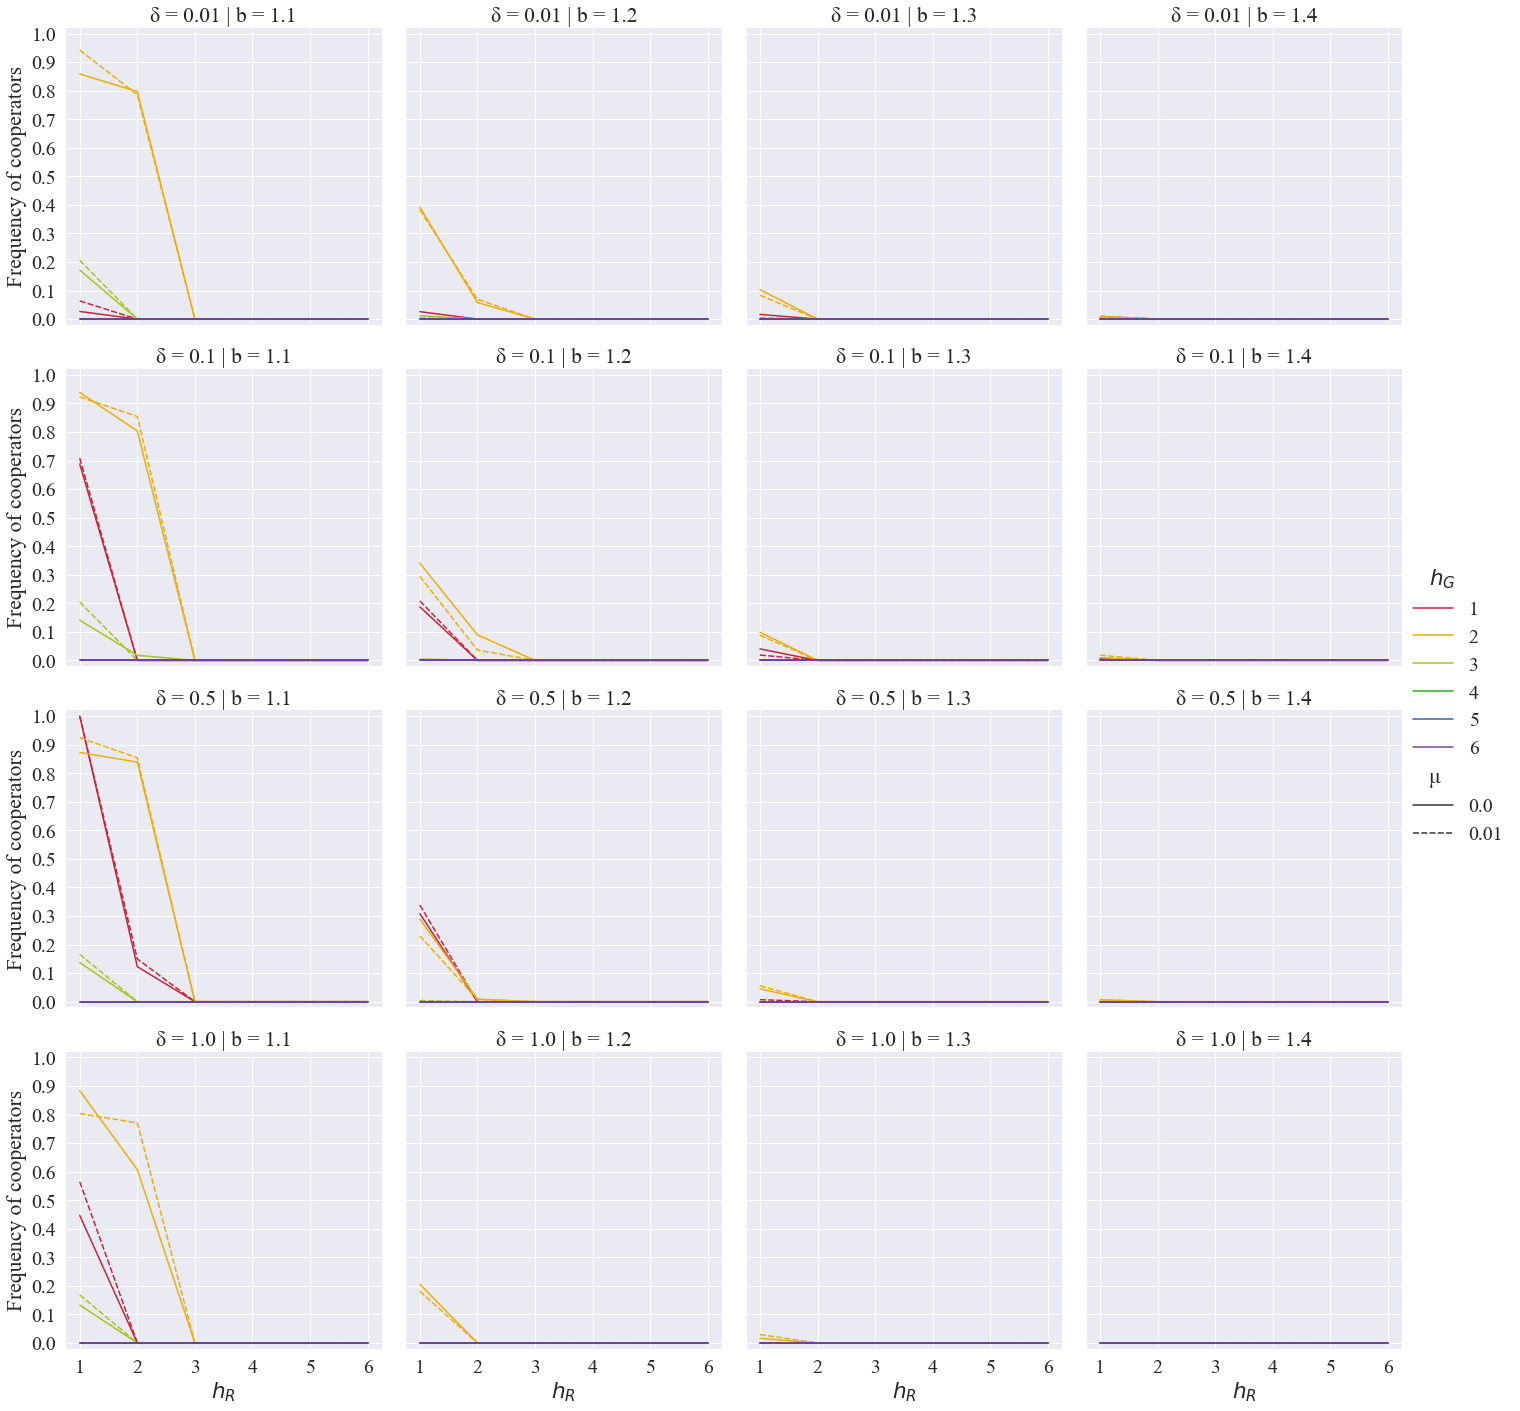

regular_4, PairWise, BD


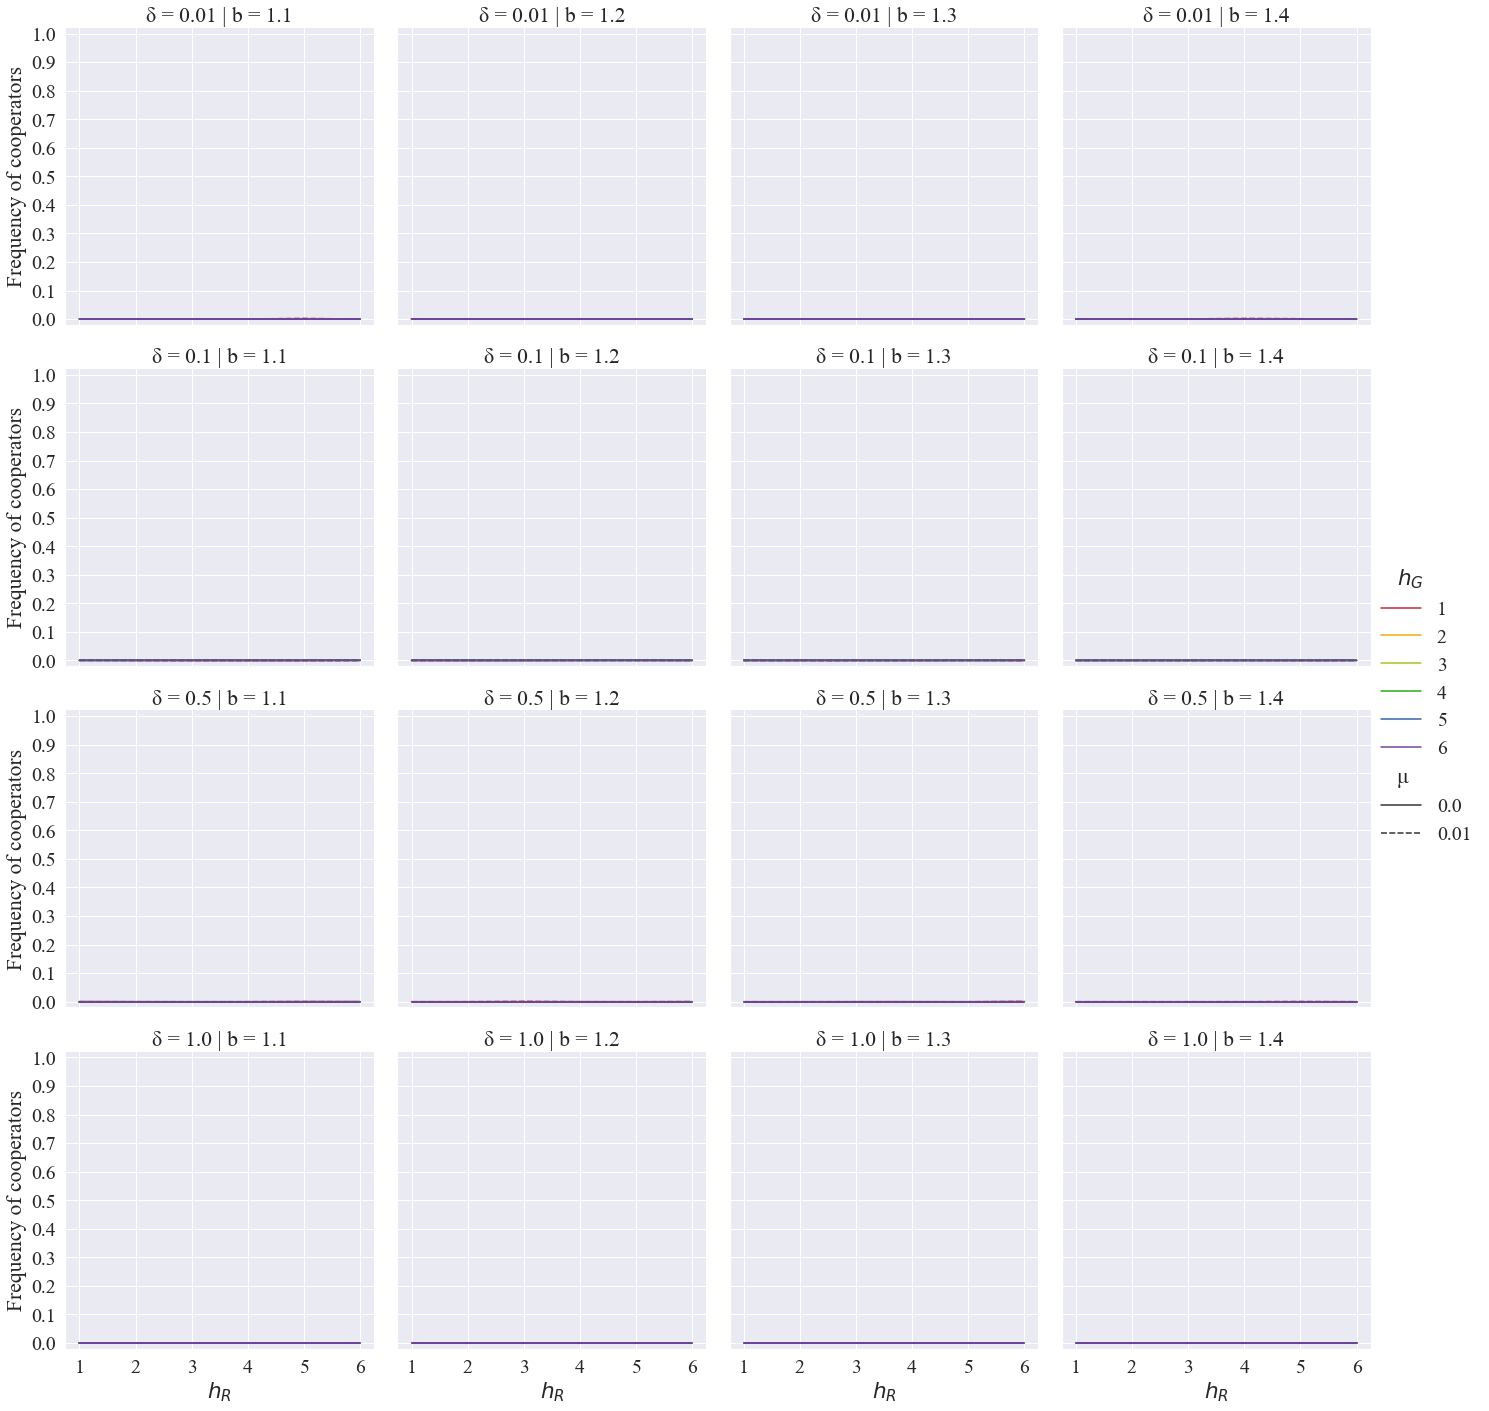

regular_4, PairWise, DB


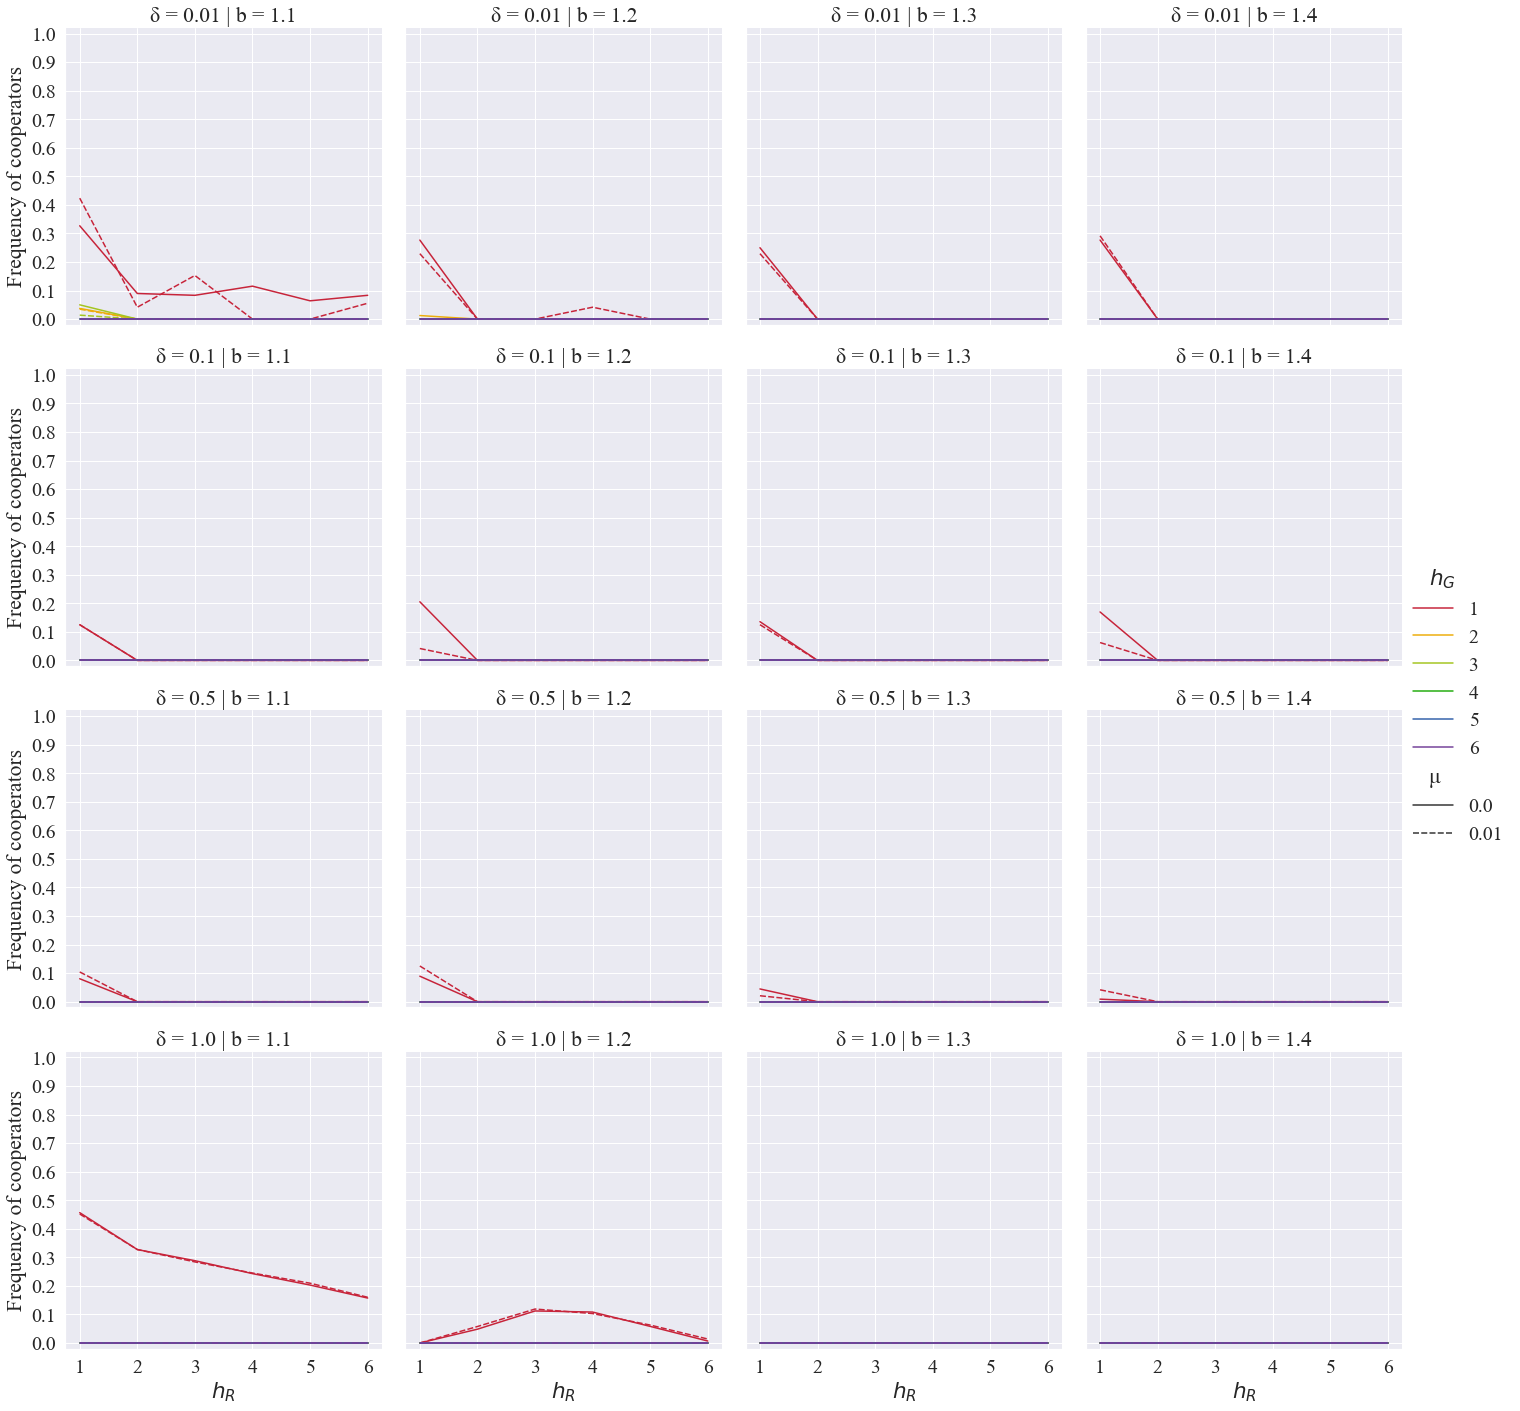

regular_4, PairWise, IM


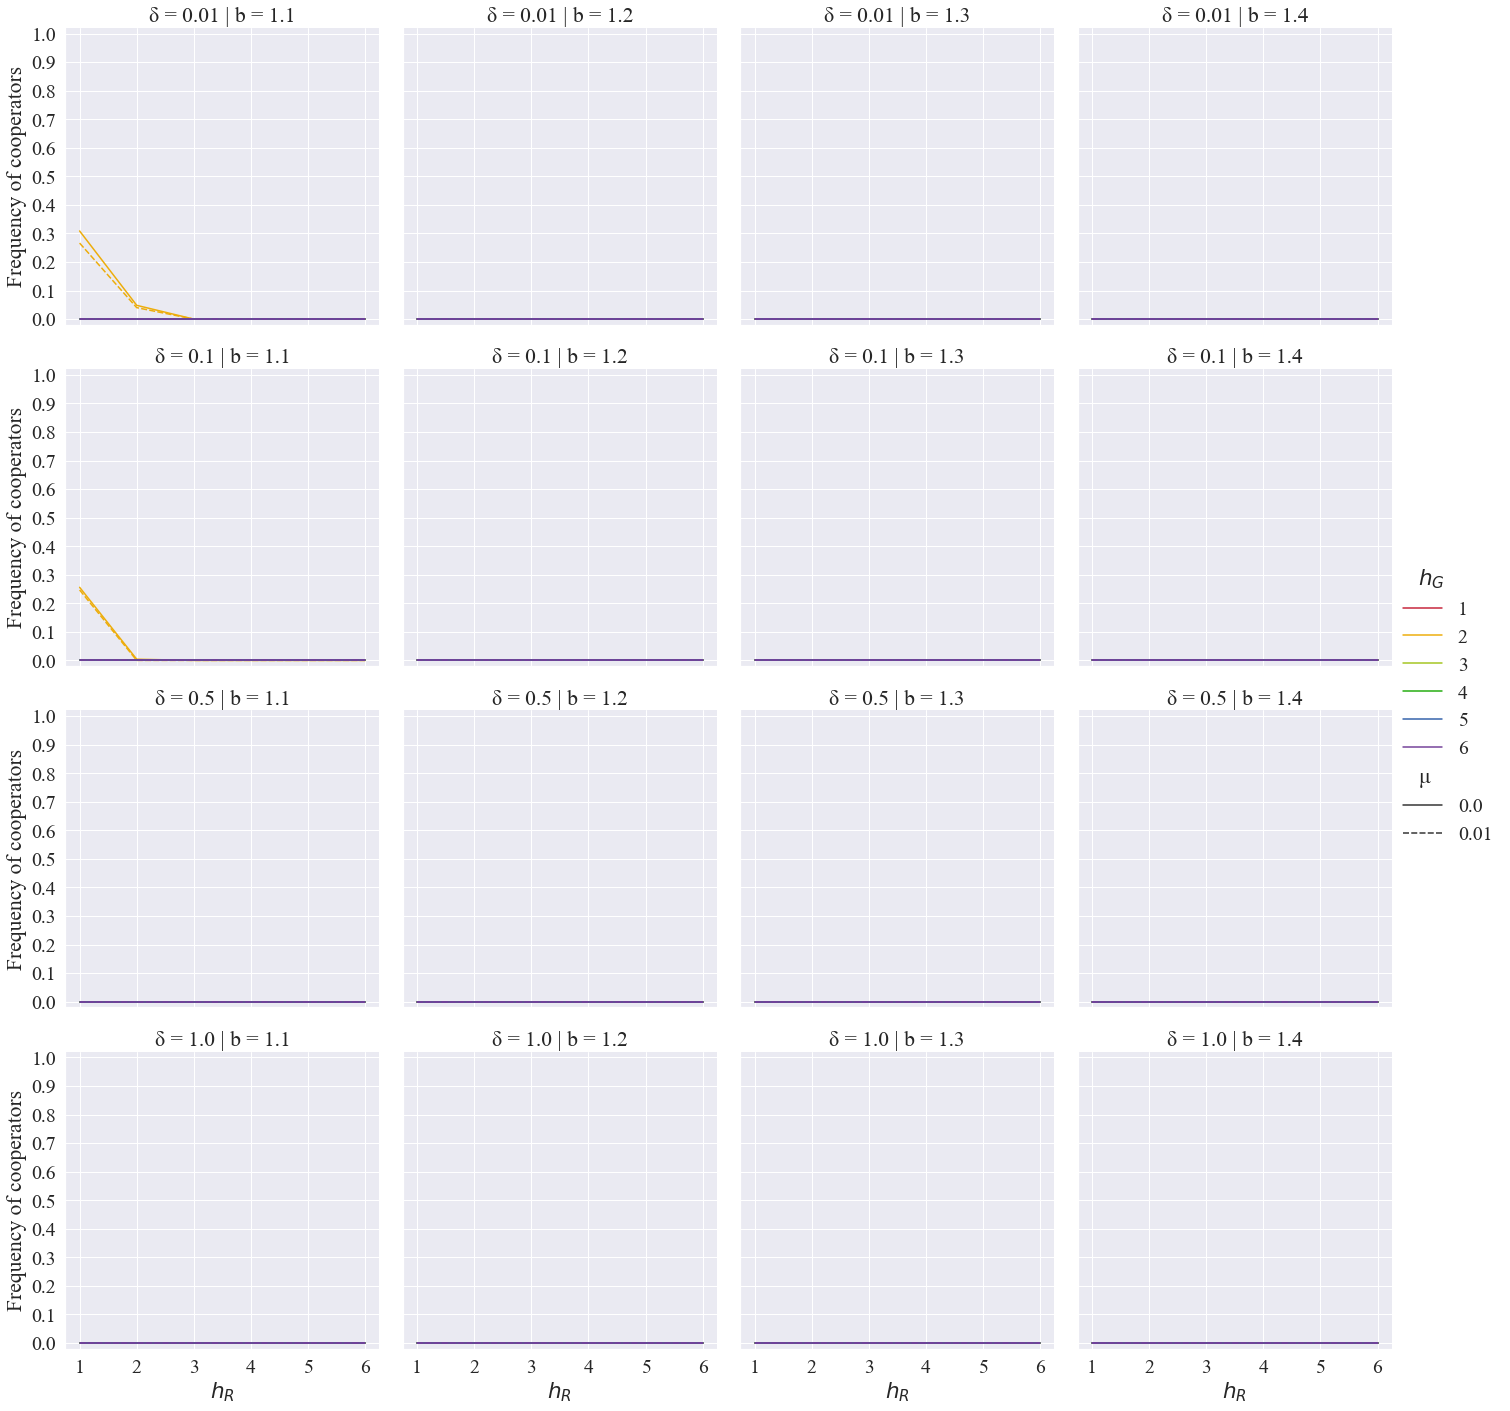

scale_free_4, PairWise, BD


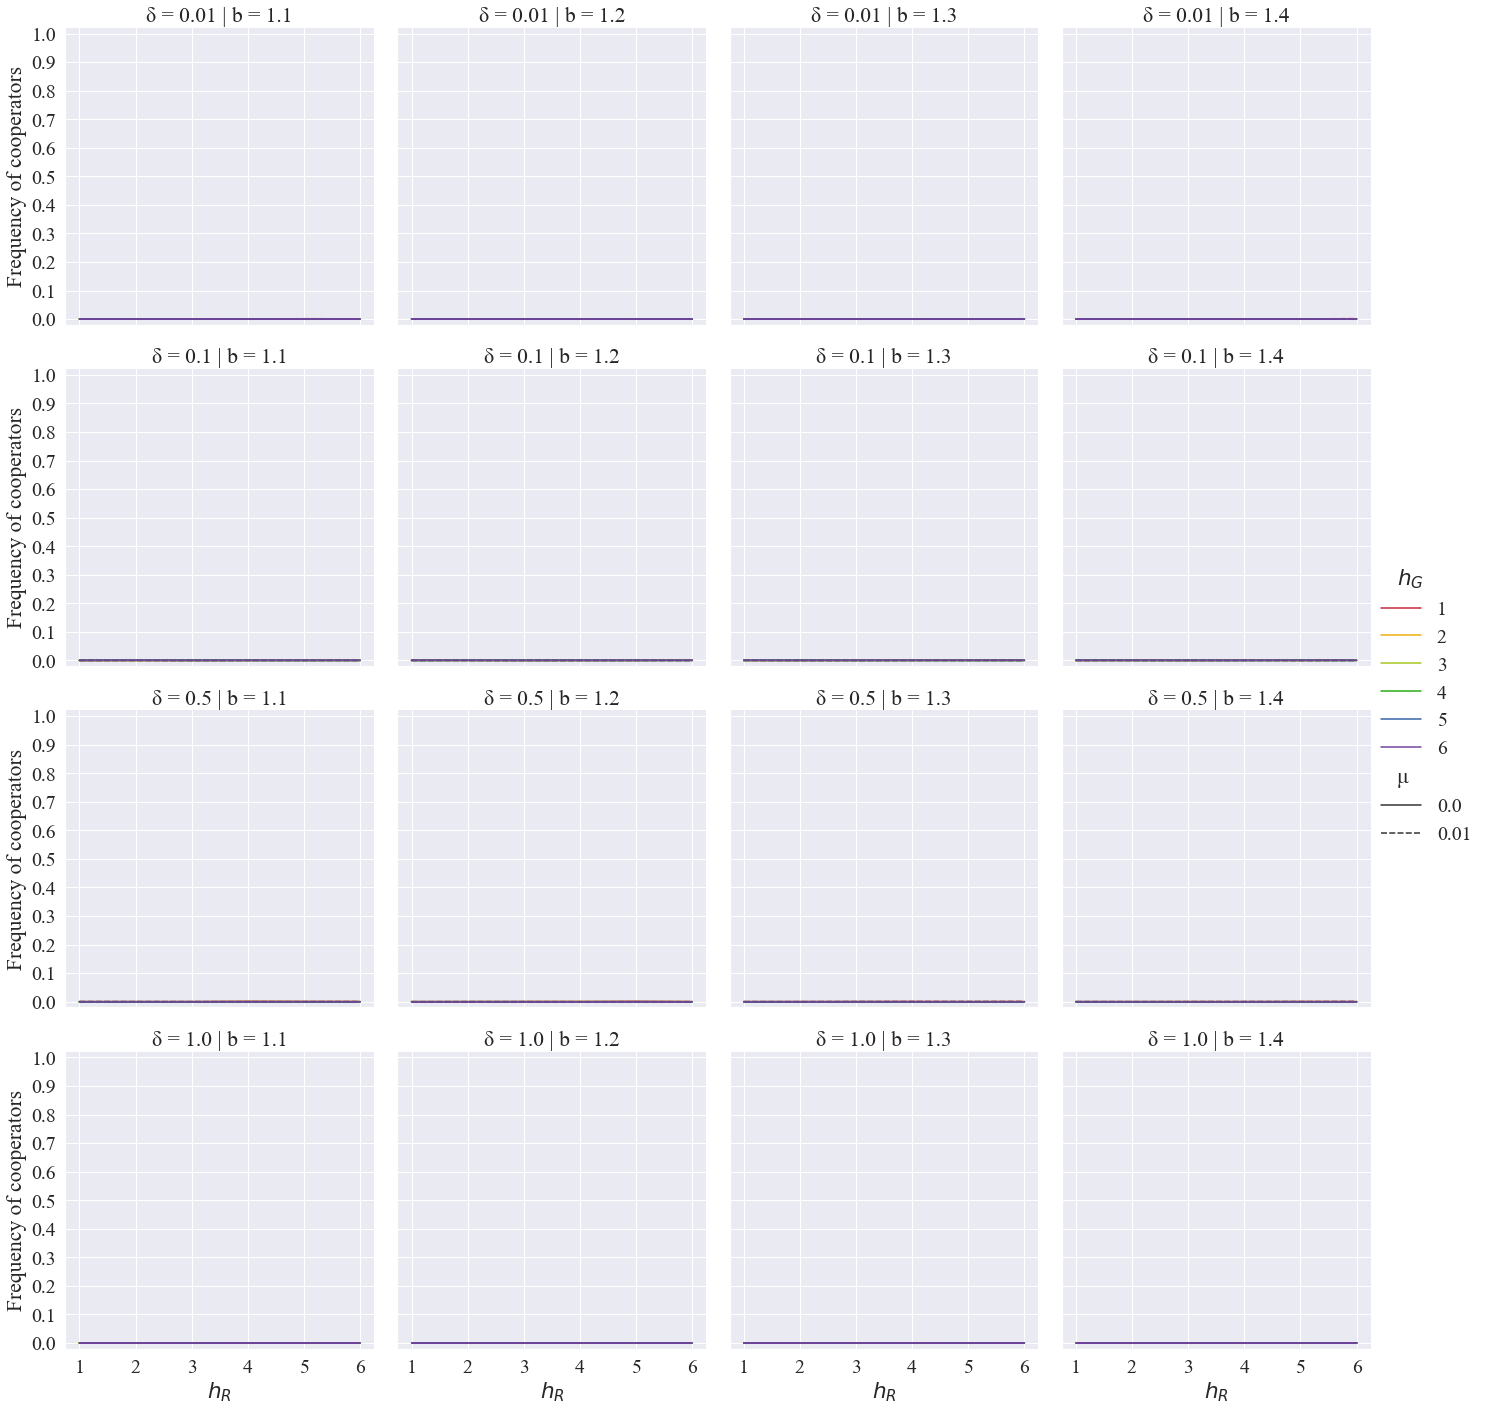

scale_free_4, PairWise, DB


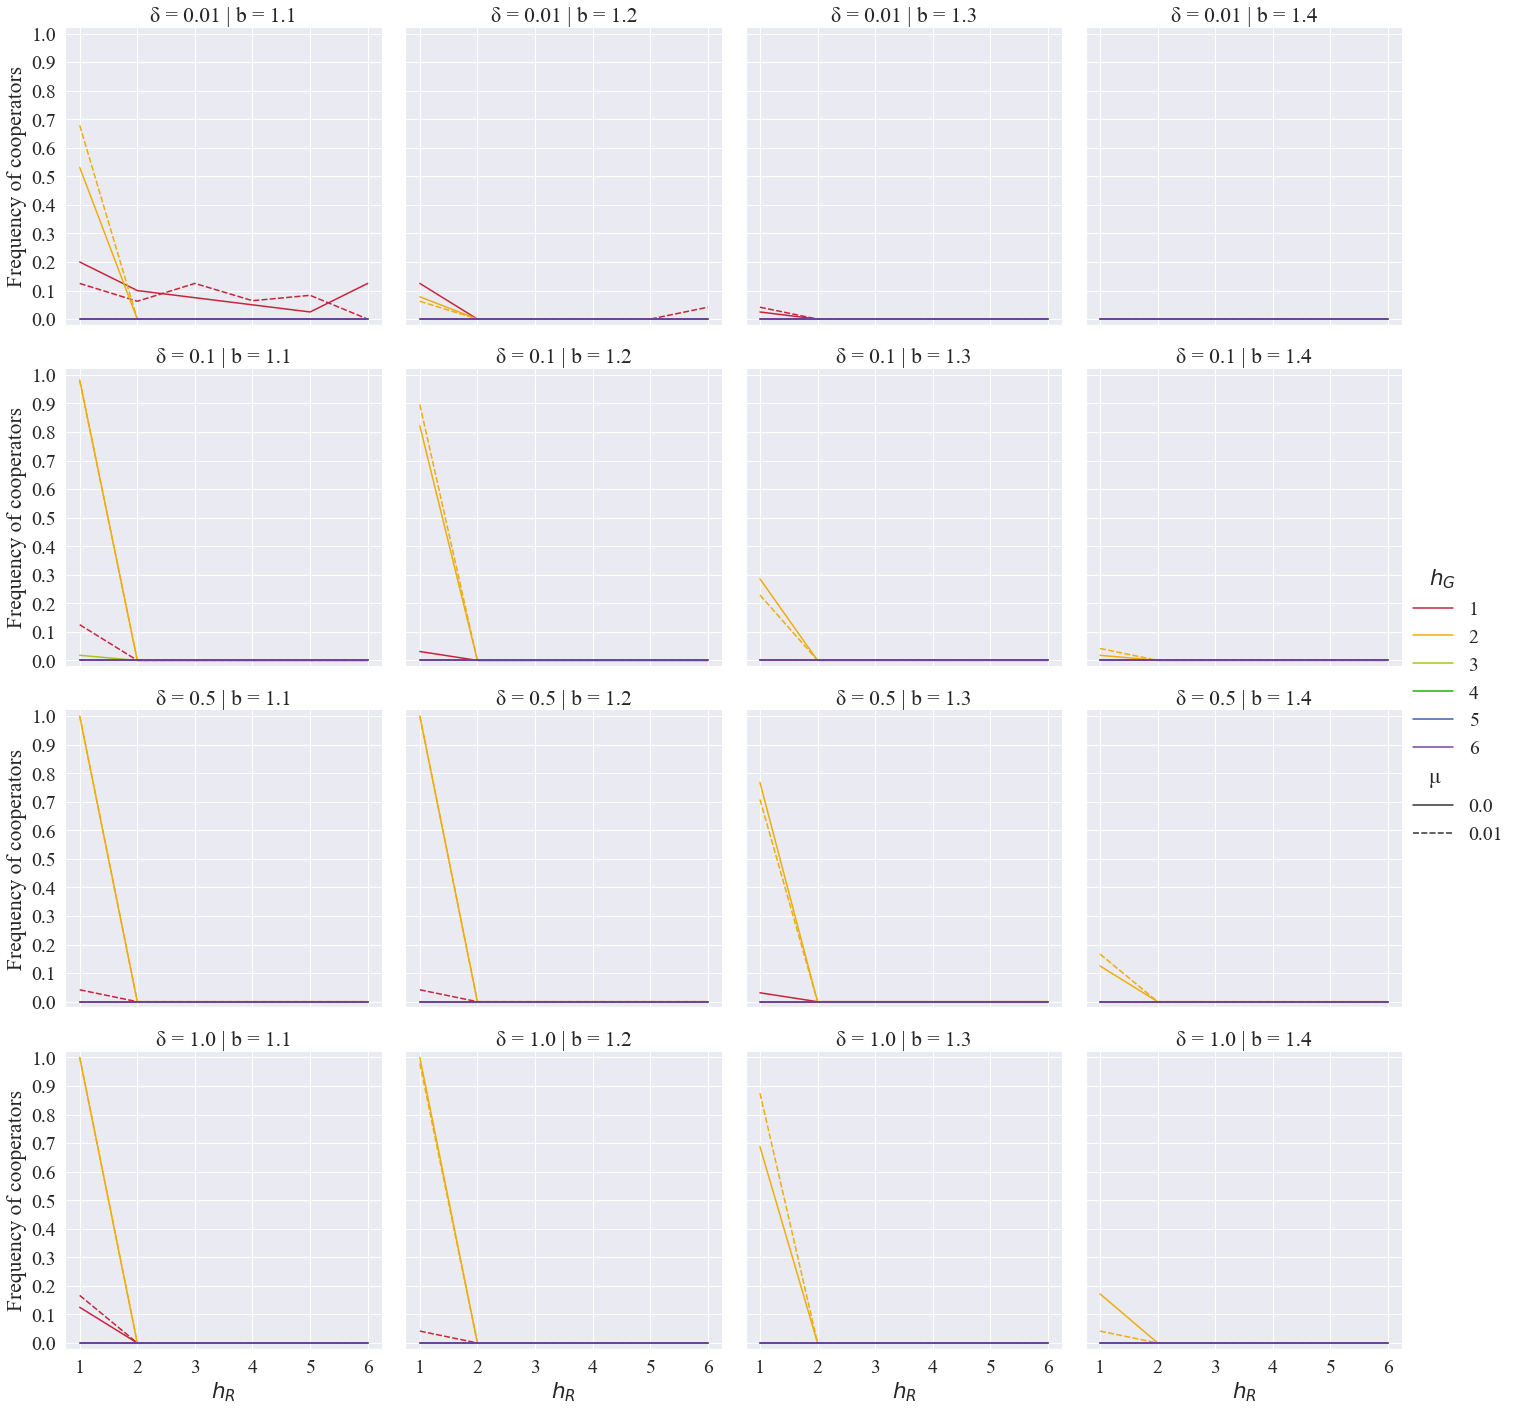

scale_free_4, PairWise, IM


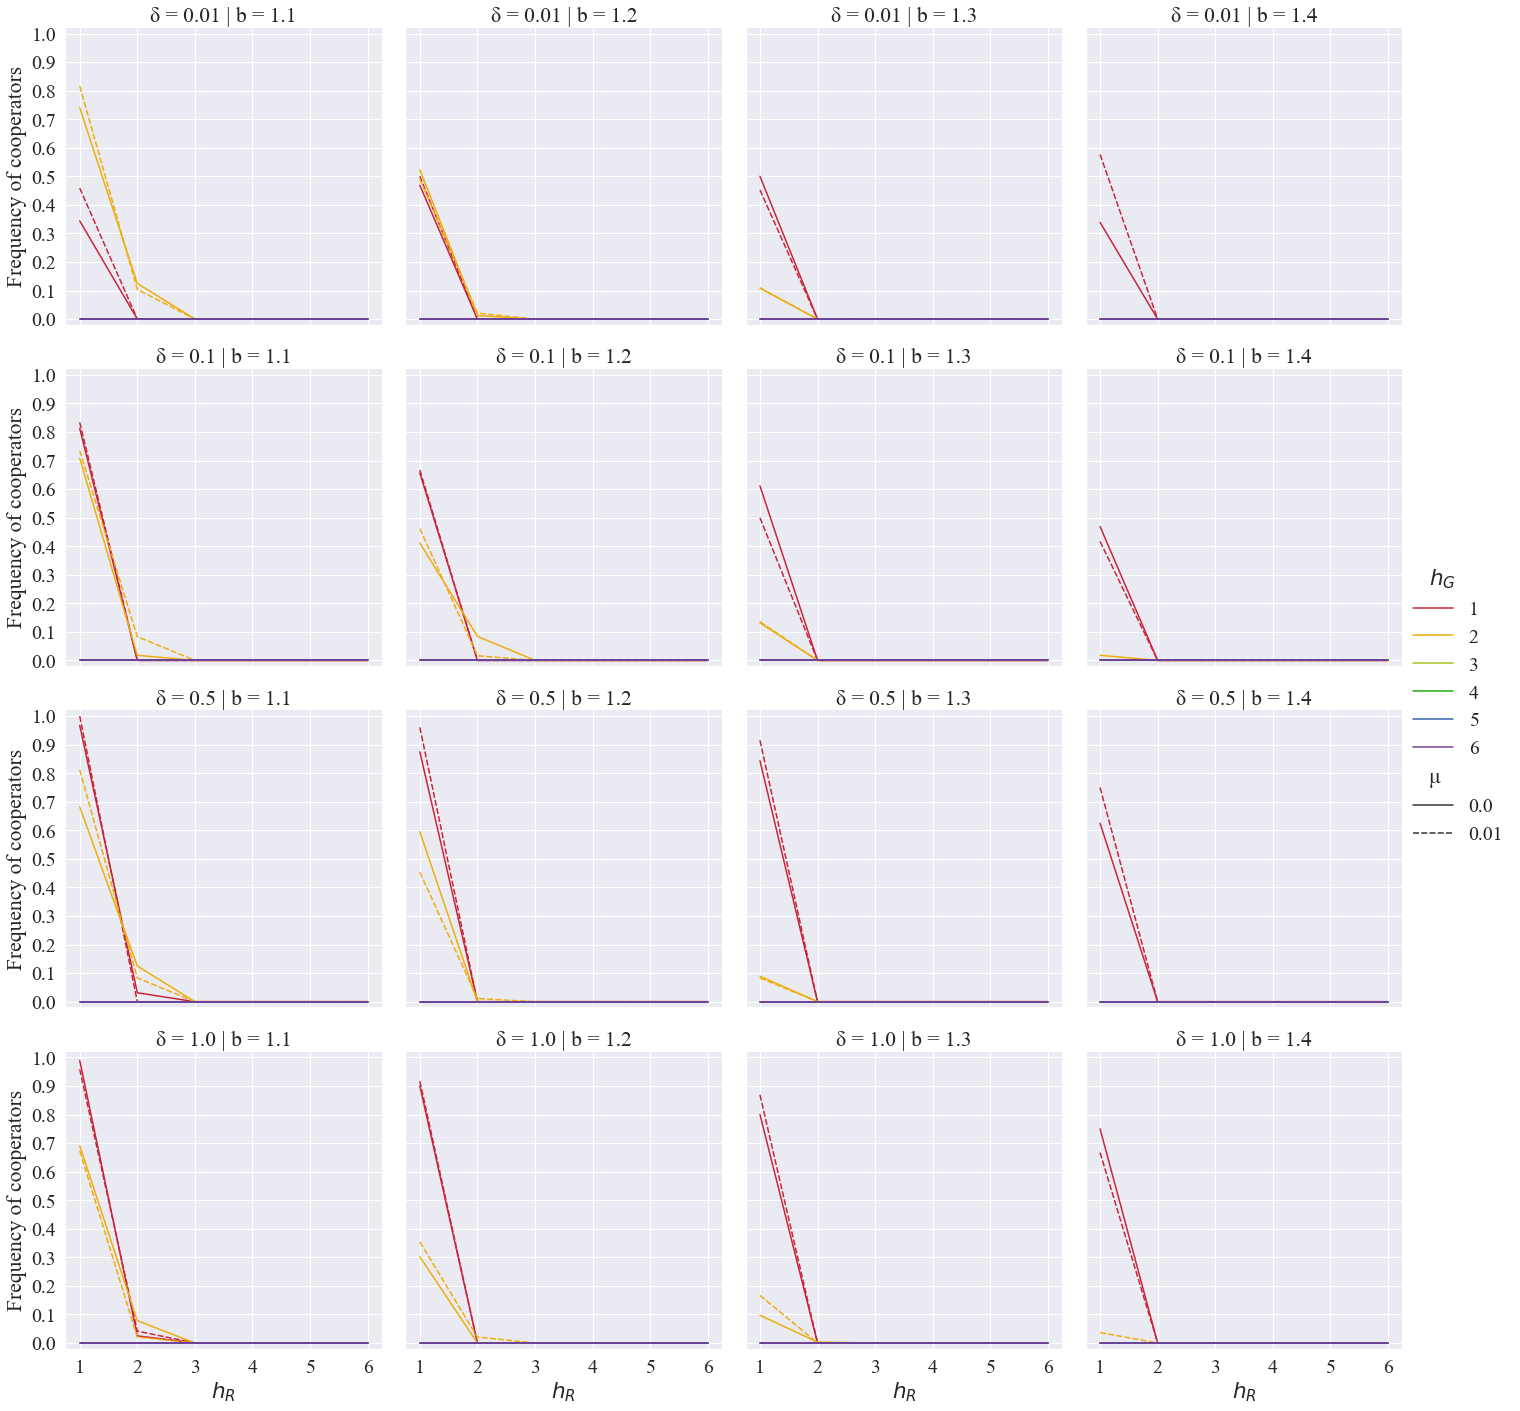

In [8]:
run(pair_df, 'hR')